## Исследование данных о российском кинопрокате



Цель: изучить фильмы, получившие государственную поддержку и ответить на вопрос, насколько такие фильмы интересны зрителю. 

Задачи:
- посмотрите, сколько фильмов выходило в прокат каждый год. 
- изучить, как менялась динамика проката по годам. 
- определить максимальную/минимальную сумму сборов
- посчитайте среднюю и медианную сумму сборов для каждого года
- оценить влияние возрастное ограничение на сборы фильмов в период с 2015 по 2019 год? 

Датасеты:

1) открытые данные Министерства культуры;

2) информация с сайта КиноПоиск. 


## Загрузка

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [ ]:
data_1 = pd.read_csv('C:\\Users\\kushn\\Documents\\Python_trainings\\Yandex_DS\\Film_release\\mkrf_movies.csv')
data_2 = pd.read_csv('C:\\Users\\kushn\\Documents\\Python_trainings\\Yandex_DS\\Film_release\\mkrf_shows.csv')

In [131]:
print("Размерность первого датафрейма:", data_1.shape)
print(data_1.info())
data_1.head(1)

Размерность первого датафрейма: (7486, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7486 entries, 0 to 7485
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  7486 non-null   object 
 1   puNumber               7486 non-null   object 
 2   show_start_date        7486 non-null   object 
 3   type                   7486 non-null   object 
 4   film_studio            7468 non-null   object 
 5   production_country     7484 non-null   object 
 6   director               7477 non-null   object 
 7   producer               6918 non-null   object 
 8   age_restriction        7486 non-null   object 
 9   refundable_support     332 non-null    float64
 10  nonrefundable_support  332 non-null    float64
 11  budget                 332 non-null    float64
 12  financing_source       332 non-null    object 
 13  ratings                6519 non-null   object 
 14  genres       

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres
0,Открытый простор,221048915,2015-11-27T12:00:00.000Z,Художественный,"Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикче...",США,Кевин Костнер,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,7.2,"боевик,драма,мелодрама"


In [132]:
print(data_2.shape)
print(data_2.info())
data_2.head(1)

(3158, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3158 entries, 0 to 3157
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   puNumber    3158 non-null   int64  
 1   box_office  3158 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 49.5 KB
None


,puNumber,box_office
0,111000113,2450.0


Данные не сольются, т.к. колонка `puNumber` в первом файле содержит строковые данные, а во втором числовые.

+ в первом файле колонка `puNumber` содержит помимо цифр слова. Заменим их на 0

In [133]:
data_1.loc[data_1.loc[:,'puNumber'].str.contains('[а-яА-Я]', regex=True), 'puNumber'] = 0

+ в первом файле колонка `puNumber` содержит пробелы. Удалим их.

In [134]:
data_1['puNumber'] = data_1['puNumber'].str.strip(' ')

+ в первом файле колонка `puNumber` содержит пропуски. Заменим их.

In [135]:
data_1.loc[data_1.loc[:,'puNumber'].isna(), 'puNumber'] = 0

+ передведем первый файл в числовое значение.

In [136]:
data_1['puNumber'] = data_1['puNumber'].astype(int)

Соеденим данные

In [137]:
raw_data = data_1.merge(data_2, how='left', left_on='puNumber', right_on='puNumber')
print(raw_data.shape)
raw_data.head(1)

(7486, 16)


,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
0,Открытый простор,221048915,2015-11-27T12:00:00.000Z,Художественный,"Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикче...",США,Кевин Костнер,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,7.2,"боевик,драма,мелодрама",NaN


In [138]:
print(data_1.shape)
print(data_2.shape)
print(raw_data.shape)

(7486, 15)
(3158, 2)
(7486, 16)


После слияния данных датасетов `mkrf_movies.csv`(7486, 15) и `mkrf_shows.csv`(3158, 2) по колонке `pu_Numbers` образовался рабочий датасет размерностью (7486, 16). Появлиась новая колонка с данными о сборах `box_office`

In [139]:
raw_data.rename(columns={'puNumber': 'pu_number'}, inplace=True)

## Предобработка данных

In [140]:
def output_info(df):
    output = []
    for col in df.columns:
        nonNull  = len(df) - df[col].isna().sum()
        nul = len(df) - nonNull
        unique = df[col].nunique()
        colType = str(df[col].dtype)
        output.append([col, nonNull, nul, unique, colType])

    output = pd.DataFrame(output)
    output.columns = ['col_name','non-null_values','null_values', 'unique', 'dtype']
    return output

In [141]:
output_info(raw_data)

,col_name,non-null_values,null_values,unique,dtype
0,title,7486,0,6772,object
1,pu_number,7486,0,7484,int32
2,show_start_date,7486,0,1965,object
3,type,7486,0,8,object
4,film_studio,7468,18,5490,object
5,production_country,7484,2,950,object
6,director,7477,9,4811,object
7,producer,6918,568,5349,object
8,age_restriction,7486,0,5,object
9,refundable_support,332,7154,34,float64


Исправим типы данных в дате

In [142]:
raw_data['show_start_date'] = pd.to_datetime(raw_data['show_start_date'], format='%Y-%m-%dT%H:%M:%S.%fZ')  

In [143]:
# check
raw_data['show_start_date'].head(2)

0   2015-11-27 12:00:00
1   2016-09-13 12:00:00
Name: show_start_date, dtype: datetime64[ns]

Колонка `ratings` содержит строковые данные. Исправим их позже.

In [144]:
raw_data['ratings'].unique()

array(['7.2', '6.6', '6.8', '7.7', '8.3', '8.0', '7.8', '8.1', '7.1',
       '6.0', '7.4', '5.8', '8.7', '6.3', '6.9', '5.0', '4.3', '7.3',
       '7.0', '6.4', nan, '8.2', '7.5', '6.7', '7.9', '5.9', '6.2', '5.6',
       '6.5', '2.4', '7.6', '6.1', '8.6', '8.5', '8.8', '5.5', '5.1',
       '5.7', '5.4', '99%', '4.4', '4.5', '5.3', '4.1', '8.4', '2.6',
       '3.8', '4.6', '4.8', '4.0', '3.0', '1.6', '4.2', '5.2', '4.7',
       '4.9', '3.9', '2.7', '3.3', '2.9', '28%', '3.7', '1.4', '3.1',
       '97%', '3.5', '3.2', '2.8', '1.5', '2.1', '2.5', '9.2', '3.4',
       '1.1', '3.6', '83%', '64%', '91%', '94%', '62%', '79%', '90%',
       '19%', '88%', '1.0', '89%', '1.3', '1.9', '1.8', '1.2', '1.7',
       '9.0', '98%', '8.9', '9.1'], dtype=object)

In [145]:
# check
# пропущенные значения бары

def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), rot =0, legend = False, fontsize = 16)
            .set_title('Сруднее количество пропусков данных в колонке' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось :) или произошла ошибка в первой части функции ')

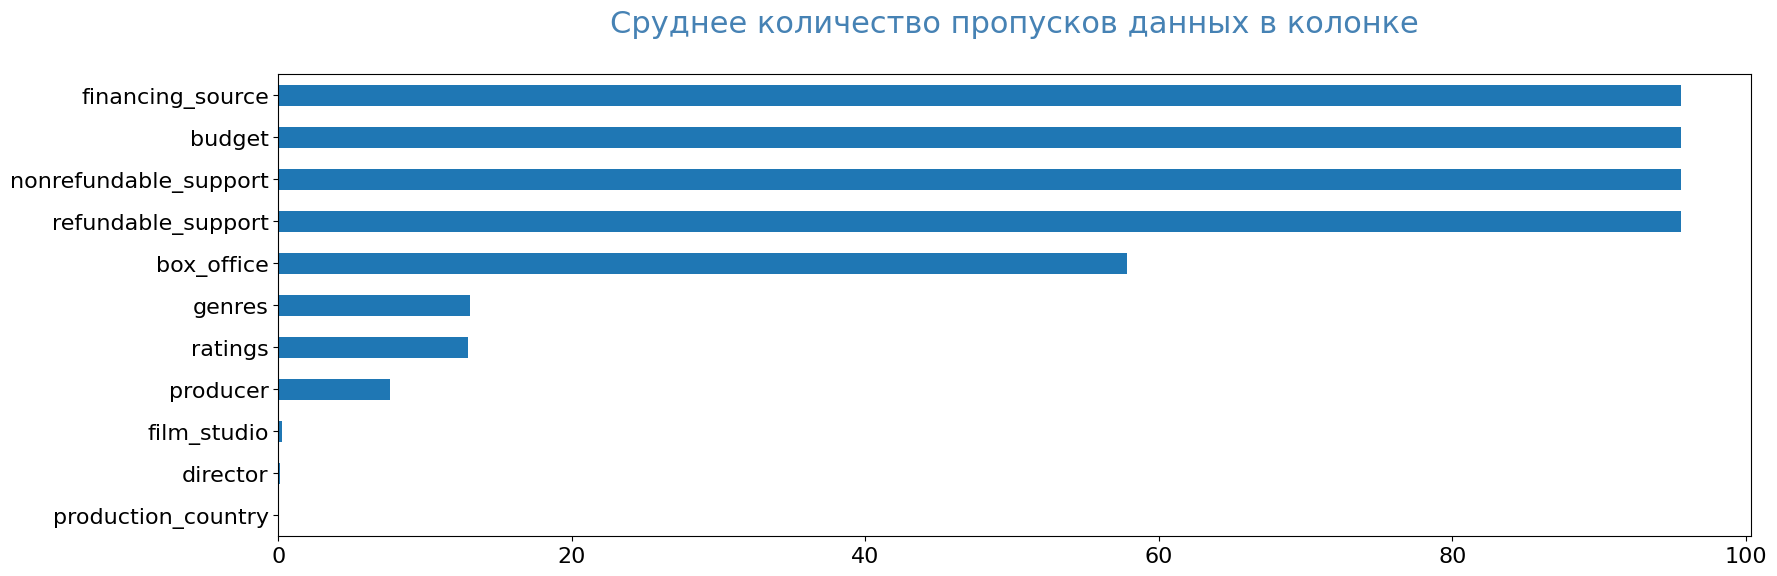

In [18]:
pass_value_barh(raw_data)

`film_studio` категориальные данные, из семи - пять тысяч уникалньные, пропуски можно заполнить "Unknown"

In [19]:
raw_data.loc[raw_data.loc[:,'film_studio'].isna(), 'film_studio'] = 'Unknown'

`production_country` 2 пропуска с явным производством в РФ

In [20]:
raw_data.loc[raw_data.loc[:,'production_country'].isna()]

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
3186,"Детский юмористический киножурнал ""Ералаш. Ну ...",111001216,2016-02-09 12:00:00,Художественный,"ООО ""Продюсерский центр ЕРАЛАШ""",NaN,"Р.Светлов, И.Магитон, А.Арутюнян, Л.Мирский, А...","ООО ""Продюсерский центр ЕРАЛАШ""",«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,7.2,"детский,комедия",194527.0
4441,Мульт личности. Выпуск 5,214000410,2010-01-25 12:00:00,Художественный,Unknown,NaN,NaN,NaN,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,4.0,"мультфильм,комедия",NaN


In [21]:
raw_data.loc[raw_data.loc[:,'production_country'].isna(), 'production_country'] = 'Россия'

`director` и `producer` категориальные данные, из семи - пять тысяч уникалньные, пропуски можно заполнить "Unknown"

`financing_source` категориальные данные для фильмов с гос.поддержкой. Пропуски можно заполнить 'Unknown'

In [22]:
raw_data.loc[raw_data.loc[:,'director'].isna(), 'director'] = 'Unknown'
raw_data.loc[raw_data.loc[:,'producer'].isna(), 'producer'] = 'Unknown'
raw_data.loc[raw_data.loc[:,'financing_source'].isna(), 'financing_source'] = 'Unknown'

`refundable_support`, `nonrefundable_support`, `budget` числовые данные для фильмов с гос.поддержкой. 

Проверим есть ли фильмы у которых нет и бюджета и сборов

In [23]:
len(raw_data.query('(refundable_support == 0 | nonrefundable_support == 0 | budget == 0) & box_office == 0'))

0

In [24]:
raw_data.loc[raw_data.loc[:,'refundable_support'].isna(), 'refundable_support'] = 0
raw_data.loc[raw_data.loc[:,'nonrefundable_support'].isna(), 'nonrefundable_support'] = 0
raw_data.loc[raw_data.loc[:,'budget'].isna(), 'budget'] = 0

`ratings` пока смешанные данные. Пропуски исправим позже.

`genres` категориальные данные. Пропуски можно заполнить 'Unknown'

In [25]:
raw_data.loc[raw_data.loc[:,'genres'].isna(), 'genres'] = 'Unknown'

`box_office` числовые данные. Пропуски можно заполнить 0

In [26]:
raw_data.loc[raw_data.loc[:,'box_office'].isna(), 'box_office'] = 0.0

In [27]:
import numpy as np

In [28]:
np.nan - 100

nan

In [29]:
0 - 100

-100

Нет полных дублей

In [30]:
raw_data.duplicated().sum()

0

Однако есть повторы в названиях и номере прокатного удостоверения, хотя они должны быть уникальными

In [31]:
print('Дубли в названиях ', raw_data['title'].duplicated().sum())
print('Дубли в номере удостоверения ', raw_data['pu_number'].duplicated().sum())

Дубли в названиях  714
Дубли в номере удостоверения  2


На примере фильма "Алекс и Эмма" можем понять откуда взялись дубли в названиях. Фильм запускался в разные года и имеет разные номера удостоверений.

In [32]:
raw_data.query('title == "Алекс и Эмма"')

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
40,Алекс и Эмма,221005015,2015-02-25 12:00:00,Художественный,"Эскейп Артистс, Франчайз Пикчерз, Рейнер-Грэйс...",США,Роб Райнер,"Тодд Блэк, Элан Грейсман, Джереми Левен, Роб Р...",«16+» - для детей старше 16 лет,0.0,0.0,0.0,Unknown,6.4,"мелодрама,комедия",0.0
41,Алекс и Эмма,221004616,2016-02-09 12:00:00,Художественный,"Эскейп Артистс, Франчайз Пикчерз, Рейнер-Грэйс...",США,Роб Райнер,"Тодд Блэк, Элан Грейсман, Джереми Левен, Роб Р...",«16+» - для детей старше 16 лет,0.0,0.0,0.0,Unknown,6.4,"мелодрама,комедия",0.0
4581,Алекс и Эмма,221156910,2010-12-17 12:00:00,Художественный,"Эскейп Артистс, Франчайз Пикчерз, Рейнер-Грэйс...",США,Роб Райнер,"Тодд Блэк, Элан Грейсман, Джереми Левен, Роб Р...",«16+» - для детей старше 16 лет,0.0,0.0,0.0,Unknown,6.4,"мелодрама,комедия",0.0


Удалим дубли по названию

In [33]:
len(raw_data['title'])

7486

In [34]:
raw_data.drop_duplicates('title', inplace=True)

In [35]:
len(raw_data['title'])

6772

In [36]:
raw_data[raw_data['pu_number'].duplicated(keep=False)]

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office


Дубли по номеру удостоверения оставляем, т.к. это разные фильмы

In [37]:
# check
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6772 entries, 0 to 7485
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   title                  6772 non-null   object        
 1   pu_number              6772 non-null   int32         
 2   show_start_date        6772 non-null   datetime64[ns]
 3   type                   6772 non-null   object        
 4   film_studio            6772 non-null   object        
 5   production_country     6772 non-null   object        
 6   director               6772 non-null   object        
 7   producer               6772 non-null   object        
 8   age_restriction        6772 non-null   object        
 9   refundable_support     6772 non-null   float64       
 10  nonrefundable_support  6772 non-null   float64       
 11  budget                 6772 non-null   float64       
 12  financing_source       6772 non-null   object        
 13  ratings 

Напишем функцию для определения пробелов в категориальных данных

In [38]:
def check_first_last_spaces(df):
    output = []
    for col in df.columns:
        if df[col].dtype == object:
            f_space = df[col].str.startswith(' ').sum()
            l_space = df[col].str.endswith(' ').sum()
            output.append([col, f_space, l_space])

    output = pd.DataFrame(output)
    output.columns = ['col_name', 'first_space_sum', 'last_space_sum']
    return output

In [39]:
check_first_last_spaces(raw_data)

,col_name,first_space_sum,last_space_sum
0,title,1,17
1,type,1351,0
2,film_studio,24,363
3,production_country,4,56
4,director,4,48
5,producer,10,123
6,age_restriction,0,0
7,financing_source,0,0
8,ratings,0,0
9,genres,0,0


Уберем начальные и конечные пробелы в категориальных данных

In [40]:
def remove_strips(df):
    for col in df.columns:
        if df[col].dtype == object:
            df[col] = df[col].str.strip(' ')
    return None

In [41]:
remove_strips(raw_data)

In [42]:
check_first_last_spaces(raw_data)

,col_name,first_space_sum,last_space_sum
0,title,0,0
1,type,0,0
2,film_studio,0,0
3,production_country,0,0
4,director,0,0
5,producer,0,0
6,age_restriction,0,0
7,financing_source,0,0
8,ratings,0,0
9,genres,0,0


Проверим

In [43]:
output_info(raw_data)

,col_name,non-null_values,null_values,unique,dtype
0,title,6772,0,6772,object
1,pu_number,6772,0,6772,int32
2,show_start_date,6772,0,1914,datetime64[ns]
3,type,6772,0,6,object
4,film_studio,6772,0,5420,object
5,production_country,6772,0,927,object
6,director,6772,0,4778,object
7,producer,6772,0,5292,object
8,age_restriction,6772,0,5,object
9,refundable_support,6772,0,34,float64


Наконец можно исправить рейтинг

In [44]:
raw_data['ratings'].unique()

array(['7.2', '6.6', '6.8', '7.7', '8.3', '8.0', '7.8', '8.1', '7.1',
       '6.0', '7.4', '5.8', '8.7', '6.3', '6.9', '5.0', '4.3', '7.3',
       '7.0', '6.4', nan, '8.2', '7.5', '6.7', '7.9', '5.9', '6.2', '5.6',
       '6.5', '2.4', '7.6', '6.1', '8.6', '8.5', '8.8', '5.5', '5.1',
       '5.7', '5.4', '99%', '4.4', '4.5', '5.3', '4.1', '8.4', '2.6',
       '3.8', '4.6', '4.8', '4.0', '3.0', '1.6', '4.2', '5.2', '4.7',
       '4.9', '3.9', '2.7', '3.3', '2.9', '28%', '3.7', '1.4', '3.1',
       '97%', '3.5', '3.2', '2.8', '1.5', '2.1', '2.5', '9.2', '3.4',
       '1.1', '3.6', '83%', '64%', '91%', '94%', '62%', '79%', '90%',
       '19%', '88%', '1.0', '89%', '1.3', '1.9', '1.8', '1.2', '1.7',
       '9.0', '98%', '8.9', '9.1'], dtype=object)

Заменим пропуски на 0

In [45]:
raw_data['ratings'].astype(str)
raw_data.loc[raw_data.loc[:,'ratings'].isna(), 'ratings'] = '0.0'
raw_data.loc[:,'ratings'].isna().sum()

0

In [46]:
raw_data['ratings'].unique()

array(['7.2', '6.6', '6.8', '7.7', '8.3', '8.0', '7.8', '8.1', '7.1',
       '6.0', '7.4', '5.8', '8.7', '6.3', '6.9', '5.0', '4.3', '7.3',
       '7.0', '6.4', '0.0', '8.2', '7.5', '6.7', '7.9', '5.9', '6.2',
       '5.6', '6.5', '2.4', '7.6', '6.1', '8.6', '8.5', '8.8', '5.5',
       '5.1', '5.7', '5.4', '99%', '4.4', '4.5', '5.3', '4.1', '8.4',
       '2.6', '3.8', '4.6', '4.8', '4.0', '3.0', '1.6', '4.2', '5.2',
       '4.7', '4.9', '3.9', '2.7', '3.3', '2.9', '28%', '3.7', '1.4',
       '3.1', '97%', '3.5', '3.2', '2.8', '1.5', '2.1', '2.5', '9.2',
       '3.4', '1.1', '3.6', '83%', '64%', '91%', '94%', '62%', '79%',
       '90%', '19%', '88%', '1.0', '89%', '1.3', '1.9', '1.8', '1.2',
       '1.7', '9.0', '98%', '8.9', '9.1'], dtype=object)

Исправим % на данные float

- заменим формат ХХ% на Х.Х%
- уберем знак %
- переведем во float

In [47]:
special_symbol = raw_data.loc[:,'ratings'].str.contains('%', regex=False)

In [48]:
raw_data.loc[special_symbol, 'ratings'] = \
raw_data[special_symbol == True]['ratings'].apply(lambda x: x[:1] + "." + x[1:])

In [49]:
raw_data.loc[:,'ratings'].unique()

array(['7.2', '6.6', '6.8', '7.7', '8.3', '8.0', '7.8', '8.1', '7.1',
       '6.0', '7.4', '5.8', '8.7', '6.3', '6.9', '5.0', '4.3', '7.3',
       '7.0', '6.4', '0.0', '8.2', '7.5', '6.7', '7.9', '5.9', '6.2',
       '5.6', '6.5', '2.4', '7.6', '6.1', '8.6', '8.5', '8.8', '5.5',
       '5.1', '5.7', '5.4', '9.9%', '4.4', '4.5', '5.3', '4.1', '8.4',
       '2.6', '3.8', '4.6', '4.8', '4.0', '3.0', '1.6', '4.2', '5.2',
       '4.7', '4.9', '3.9', '2.7', '3.3', '2.9', '2.8%', '3.7', '1.4',
       '3.1', '9.7%', '3.5', '3.2', '2.8', '1.5', '2.1', '2.5', '9.2',
       '3.4', '1.1', '3.6', '8.3%', '6.4%', '9.1%', '9.4%', '6.2%',
       '7.9%', '9.0%', '1.9%', '8.8%', '1.0', '8.9%', '1.3', '1.9', '1.8',
       '1.2', '1.7', '9.0', '9.8%', '8.9', '9.1'], dtype=object)

In [50]:
raw_data['ratings'] = raw_data['ratings'].str.replace('%', '', regex=False)

In [51]:
raw_data.loc[:,'ratings'].unique()

array(['7.2', '6.6', '6.8', '7.7', '8.3', '8.0', '7.8', '8.1', '7.1',
       '6.0', '7.4', '5.8', '8.7', '6.3', '6.9', '5.0', '4.3', '7.3',
       '7.0', '6.4', '0.0', '8.2', '7.5', '6.7', '7.9', '5.9', '6.2',
       '5.6', '6.5', '2.4', '7.6', '6.1', '8.6', '8.5', '8.8', '5.5',
       '5.1', '5.7', '5.4', '9.9', '4.4', '4.5', '5.3', '4.1', '8.4',
       '2.6', '3.8', '4.6', '4.8', '4.0', '3.0', '1.6', '4.2', '5.2',
       '4.7', '4.9', '3.9', '2.7', '3.3', '2.9', '2.8', '3.7', '1.4',
       '3.1', '9.7', '3.5', '3.2', '1.5', '2.1', '2.5', '9.2', '3.4',
       '1.1', '3.6', '9.1', '9.4', '9.0', '1.9', '1.0', '8.9', '1.3',
       '1.8', '1.2', '1.7', '9.8'], dtype=object)

In [52]:
raw_data['ratings'] = raw_data['ratings'].astype(float)

А вот теперь заполним 0.0 средним значением рейтинга

In [53]:
print(f"{raw_data['ratings'].mean():.1f}")
print(f"{raw_data['ratings'].median():.1f}")

5.5
6.4


## EDA

In [54]:
#raw_data.loc[raw_data.loc[:,'ratings'] == 0, 'ratings'] = round(raw_data['ratings'].mean(),1)

In [55]:
output_info(raw_data)

,col_name,non-null_values,null_values,unique,dtype
0,title,6772,0,6772,object
1,pu_number,6772,0,6772,int32
2,show_start_date,6772,0,1914,datetime64[ns]
3,type,6772,0,6,object
4,film_studio,6772,0,5420,object
5,production_country,6772,0,927,object
6,director,6772,0,4778,object
7,producer,6772,0,5292,object
8,age_restriction,6772,0,5,object
9,refundable_support,6772,0,34,float64


In [56]:
mask = raw_data.assign(budget_check = lambda x:
                       (x['refundable_support'] + x['nonrefundable_support'] > x['budget']))['budget_check']
len(raw_data[mask])

17

17 фильмов имеют общий бюджет 0 при наличии возвратного и невозвратного финансирования. Заполним 0 суммой значений.

In [57]:
raw_data.loc[mask, 'budget'] = raw_data.loc[mask, 'refundable_support'] + raw_data.loc[mask, 'nonrefundable_support']

Оценим колонку возвратного бюджета

In [58]:
raw_data['year'] = raw_data['show_start_date'].dt.year

In [59]:
raw_data.query('refundable_support !=0')['refundable_support'].describe().apply(lambda x: '{:_.0f}'.format(x))

count            109
mean      35_174_312
std       31_527_043
min        3_500_000
25%       15_000_000
50%       25_000_000
75%       50_000_000
max      180_000_000
Name: refundable_support, dtype: object

In [60]:
def violin_graph(data, col, name, x):
    plt.figure(figsize=(10,5))
    sns.violinplot(
    data=data[data[col] !=0],
    y=col,
    x=x)

    plt.title(name,fontsize=14)
    plt.xlabel(x, fontsize=10)
    plt.ylabel(col,fontsize=10)
    plt.show()

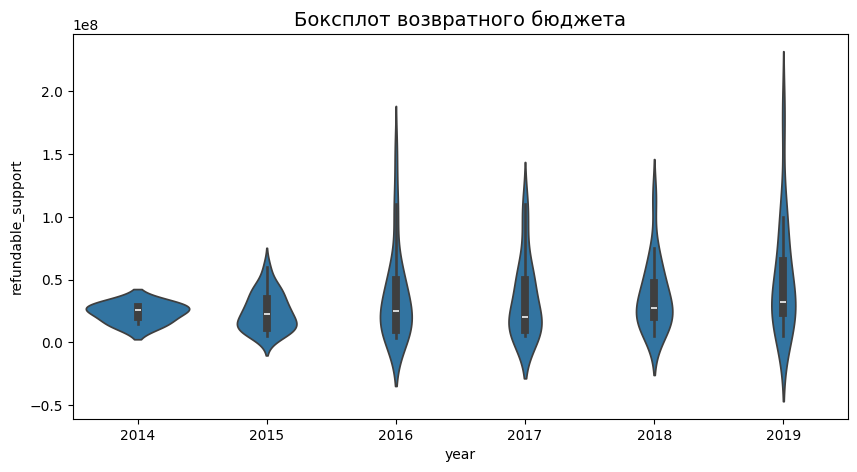

In [61]:
violin_graph(raw_data, 'refundable_support', "Боксплот возвратного бюджета", 'year')

В колонке `refundable_support` особых отклонений не обнаружено. Есть несколько выбросов по бюджетам 2016 и 2019 годов

Оценим колонку невозвратного бюджета

In [62]:
raw_data.query('nonrefundable_support !=0')['nonrefundable_support'].describe().apply(lambda x: '{:_.0f}'.format(x))

count            320
mean      49_411_526
std       57_228_145
min        3_000_000
25%       25_000_000
50%       30_000_000
75%       45_000_000
max      400_000_000
Name: nonrefundable_support, dtype: object

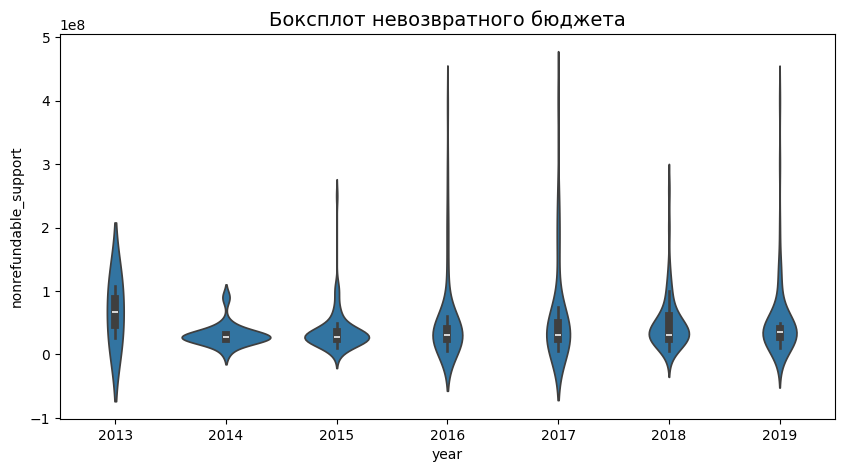

In [63]:
violin_graph(raw_data, 'nonrefundable_support', "Боксплот невозвратного бюджета", 'year')

С 2015 года появлиь выбросы по невозвратным бюджетам

Посмотрим выбросы на примере 2017 года. Выбросами будут считаться невозвратные бюджеты выше верхней границы Q3

In [64]:
max_q3_2017 = raw_data.query('year == 2017 and nonrefundable_support !=0')['nonrefundable_support'].quantile(0.75)

mean_budget = raw_data[raw_data['nonrefundable_support'] <= max_q3_2017]
return_share_mean = len(raw_data[(raw_data['nonrefundable_support'] <= max_q3_2017)
                                  & (raw_data['budget'] > raw_data['box_office'])
                                  & (raw_data['box_office'] !=0)]) / len(mean_budget)

non_normal_budget = raw_data[raw_data['nonrefundable_support'] > max_q3_2017]
return_share_non = len(raw_data[(raw_data['nonrefundable_support'] > max_q3_2017)
                                & (raw_data['budget'] > raw_data['box_office'])
                                & (raw_data['box_office'] !=0)]) / len(non_normal_budget)


print("Количество фильмов сo средними невозвратными бюджетмами в 2017 году:", len(mean_budget))
print(f'Доля этих же фильмов сборы которых превысили бюджет в 2017 году: {return_share_mean:.2%}')
print("Количество фильмов с аномально высокими невозвратными бюджетмами в 2017 году:", len(non_normal_budget))
print(f'Доля этих же фильмов сборы которых превысили бюджет в 2017 году: {return_share_non:.2%}')

Количество фильмов сo средними невозвратными бюджетмами в 2017 году: 6705
Доля этих же фильмов сборы которых превысили бюджет в 2017 году: 2.89%
Количество фильмов с аномально высокими невозвратными бюджетмами в 2017 году: 67
Доля этих же фильмов сборы которых превысили бюджет в 2017 году: 64.18%


PearsonRResult(statistic=0.18198595290529287, pvalue=1.6315647549745037e-51)
PearsonRResult(statistic=0.24057559119411415, pvalue=9.103082105792709e-90)
PearsonRResult(statistic=0.21321729934251576, pvalue=1.8076678300221647e-70)


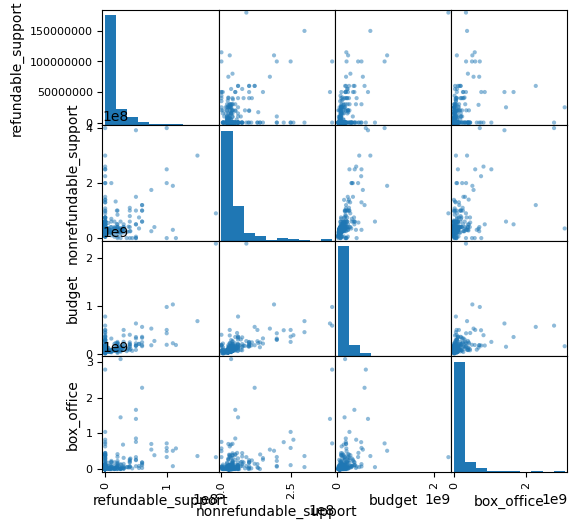

In [65]:
pd.plotting.scatter_matrix(raw_data.query('budget != 0 and box_office !=0')
                           [['refundable_support', 'nonrefundable_support', 'budget', 'box_office']], figsize=(6,6));
print(stats.pearsonr(raw_data['refundable_support'], raw_data['box_office']))
print(stats.pearsonr(raw_data['nonrefundable_support'], raw_data['box_office']))
print(stats.pearsonr(raw_data['budget'], raw_data['box_office']))

Высокие бюджеты невозратного финансирования повышают вероятность окупаемости фильма 

Оценим колонку общего бюджета

In [66]:
raw_data.query('budget !=0')['budget'].describe().apply(lambda x: '{:_.0f}'.format(x))

count              329
mean       129_377_615
std        182_473_662
min          6_000_000
25%         45_483_233
50%         70_876_172
75%        150_000_000
max      2_305_074_303
Name: budget, dtype: object

In [67]:
raw_data[raw_data['budget'] == raw_data['budget'].max()]

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office,year
7114,Тайна Печати Дракона,111012819,2019-09-12 12:00:00,Художественный,"ООО ""Кинокомпания ""СТВ""; ООО ""РФГ Корп""; ООО ""...",Россия-Китай,О.Степченко,"С.Сельянов, А.Петрухин",«6+» - для детей старше 6 лет,180000000.0,90000000.0,2.305074e+09,Фонд кино,5.8,"приключения,фэнтези",3.335971e+08,2019


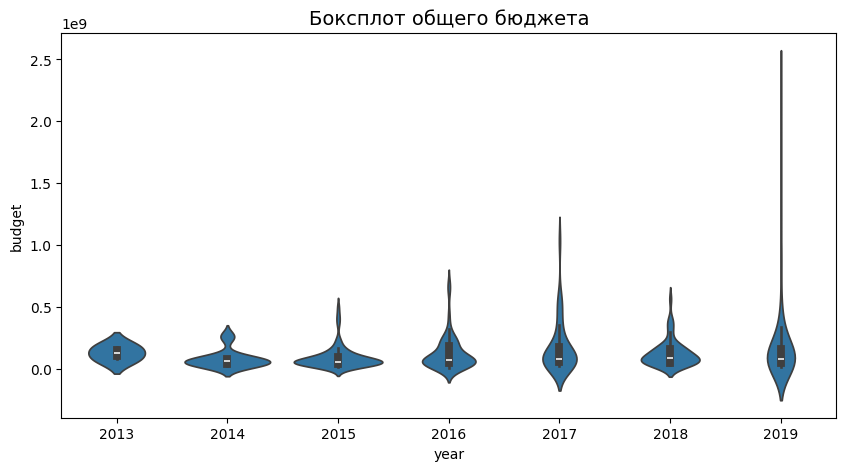

In [68]:
violin_graph(raw_data, 'budget', "Боксплот общего бюджета", 'year')

Выбросы по сборам в 2019 году.

In [69]:
max_q3_2019_budget = raw_data.query('year == 2019 and budget !=0')['budget'].quantile(0.75)

mean_budget = raw_data[raw_data['budget'] <= max_q3_2019_budget]
return_share_mean = len(raw_data[(raw_data['budget'] <= max_q3_2019_budget)
                                  & (raw_data['budget'] > raw_data['box_office'])
                                  & (raw_data['box_office'] !=0)]) / len(mean_budget)

non_normal_budget = raw_data[raw_data['budget'] > max_q3_2019_budget]
return_share_non = len(raw_data[(raw_data['budget'] > max_q3_2019_budget)
                                & (raw_data['budget'] > raw_data['box_office'])
                                & (raw_data['box_office'] !=0)]) / len(non_normal_budget)


print("Количество фильмов сo средними бюджетмами в 2019 году:", len(mean_budget))
print(f'Доля этих же фильмов сборы которых превысили бюджет в 2019 году: {return_share_mean:.2%}')
print("Количество фильмов с аномально высокими бюджетмами в 2019 году:", len(non_normal_budget))
print(f'Доля этих же фильмов сборы которых превысили бюджет в 2019 году: {return_share_non:.2%}')


Количество фильмов сo средними бюджетмами в 2019 году: 6699
Доля этих же фильмов сборы которых превысили бюджет в 2019 году: 2.87%
Количество фильмов с аномально высокими бюджетмами в 2019 году: 73
Доля этих же фильмов сборы которых превысили бюджет в 2019 году: 61.64%


Сборы

In [70]:
raw_data.query('box_office !=0')['box_office'].describe().apply(lambda x: '{:_.0f}'.format(x))

count            2_993
mean        76_238_955
std        238_555_571
min                 40
25%            135_211
50%          2_487_021
75%         24_101_208
max      3_073_568_691
Name: box_office, dtype: object

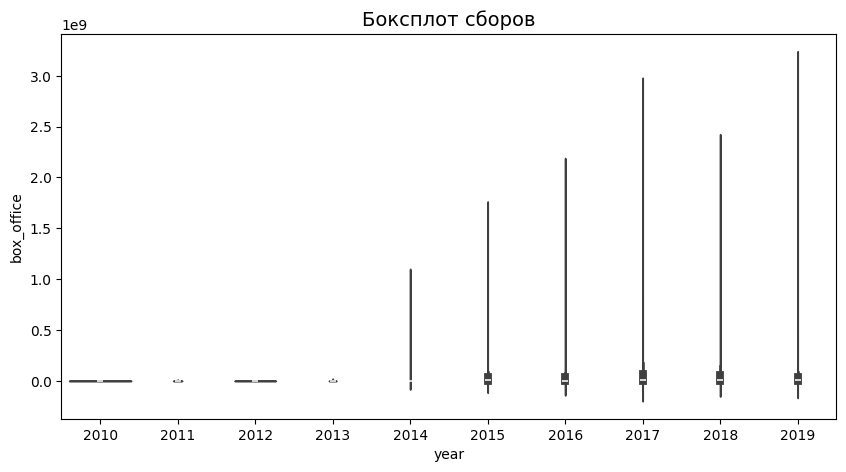

In [71]:
violin_graph(raw_data, 'box_office', "Боксплот сборов", 'year')

In [72]:
max_q3_2019_box_office = raw_data.query('year == 2019 and box_office !=0 and budget != 0')['box_office'].quantile(0.75)

print('Количество спонсированных государством фильмов с аномально высокими сборами в 2019 году:',
      len(raw_data[(raw_data['box_office'] > max_q3_2019_box_office) & (raw_data['budget'] != 0)]))


Количество спонсированных государством фильмов с аномально высокими сборами в 2019 году: 77


Есть фильмы с подозрительно низкими сборами (минимальные 40).

In [73]:
raw_data['year'] = raw_data['show_start_date'].dt.year

In [74]:
raw_data.reset_index(inplace=True)

In [75]:
def extract_value(df, col):
    for i in range(len(df)):
        df.loc[i:i, 'main_' + col] = df.loc[i:i, col].values[0].split(',')[0]
    return df.head(1)

In [76]:
extract_value(raw_data, 'director')

C:\Users\kushn\AppData\Local\Temp\ipykernel_10356\3668262857.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Кевин Костнер' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[i:i, 'main_' + col] = df.loc[i:i, col].values[0].split(',')[0]


,index,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office,year,main_director
0,0,Открытый простор,221048915,2015-11-27 12:00:00,Художественный,"Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикче...",США,Кевин Костнер,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",«18+» - запрещено для детей,0.0,0.0,0.0,Unknown,7.2,"боевик,драма,мелодрама",0.0,2015,Кевин Костнер


In [77]:
extract_value(raw_data, 'genres')

C:\Users\kushn\AppData\Local\Temp\ipykernel_10356\3668262857.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'боевик' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[i:i, 'main_' + col] = df.loc[i:i, col].values[0].split(',')[0]


,index,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office,year,main_director,main_genres
0,0,Открытый простор,221048915,2015-11-27 12:00:00,Художественный,"Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикче...",США,Кевин Костнер,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",«18+» - запрещено для детей,0.0,0.0,0.0,Unknown,7.2,"боевик,драма,мелодрама",0.0,2015,Кевин Костнер,боевик


- Посчитайте, какую долю от общего бюджета фильма составляет государственная поддержка.

In [78]:
gov_support_share =\
raw_data.assign\
         (budget_share = lambda x:\
          (x['refundable_support'] + x['nonrefundable_support']) / x['budget'])\
         ['budget_share']
gov_support_share.describe()

count    329.000000
mean       0.542518
std        0.197433
min        0.044043
25%        0.384615
50%        0.615385
75%        0.661977
max        1.000000
Name: budget_share, dtype: float64

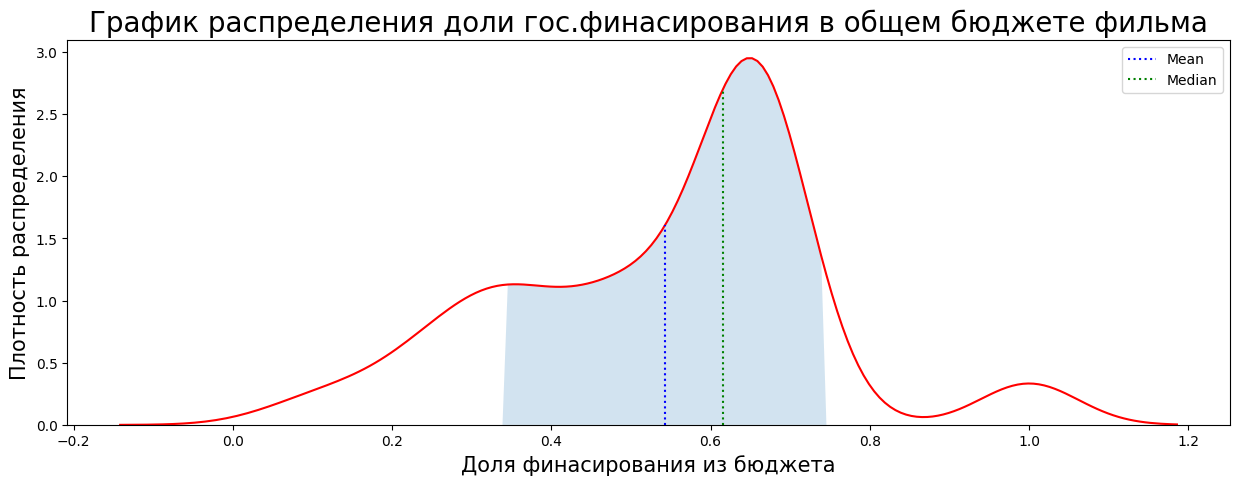

In [87]:
x = raw_data.assign\
         (budget_share = lambda x:\
          (x['refundable_support'] + x['nonrefundable_support']) / x['budget'])\
         ['budget_share']
fig, ax = plt.subplots(figsize=(15, 5))
sns.kdeplot(x, color='red', ax=ax)
kdeline = ax.lines[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()
Mean = x.mean()
Median = x.median()
sdev = x.std()
left = Mean - sdev
right = Mean + sdev
plt.title("График распределения доли гос.финасирования в общем бюджете фильма",fontsize=20)
plt.xlabel("Доля финасирования из бюджета",fontsize=15)
plt.ylabel("Плотность распределения",fontsize=15)
ax.vlines(Mean, 0, np.interp(Mean, xs, ys), label='Mean', color='blue', ls=':')
ax.vlines(Median, 0, np.interp(Median, xs, ys),label='Median', color='green', ls=':')
ax.fill_between(xs, 0, ys, where=(left <= xs) & (xs <= right), interpolate=True, alpha=0.2)
plt.legend()
plt.show()

In [80]:
release_count = pd.DataFrame(raw_data.query('box_office != 0')['year'].groupby(raw_data['year']).count())
release_count.columns = ['amount_films']
release_count['share_of_release'] = round(raw_data.query('box_office != 0')['year'].groupby(raw_data['year']).count() /\
raw_data['year'].groupby(raw_data['year']).count(),2)

release_count

,amount_films,share_of_release
year,,
2010,84,0.11
2011,98,0.21
2012,111,0.21
2013,171,0.29
2014,251,0.34
2015,428,0.65
2016,500,0.65
2017,356,0.71
2018,472,0.54


In [81]:
max_value = release_count['share_of_release'].max()
print(f"Максимальная доля релизов в {max_value:.0%} \
была в {release_count[release_count['share_of_release'] == max_value].index.item()}")

Максимальная доля релизов в 71% была в 2017


In [82]:
print(f"Доля фильмов с информацией о прокате: \
      {len(raw_data.query('box_office != 0')) / len(raw_data):.0%}")

Доля фильмов с информацией о прокате:       44%


- Изучите, как менялась динамика проката по годам. В каком году сумма сборов была минимальной? А максимальной?

In [83]:
max_box_office =raw_data.query('box_office != 0')['box_office'].describe()['max']
min_box_office =raw_data.query('box_office != 0')['box_office'].describe()['min']

print(f"Максимальные сборы в {max_box_office} \
были в {raw_data[raw_data['box_office'] == max_box_office]['year'].item()} году")

print(f"Минимальные сборы в {min_box_office} \
были в {raw_data[raw_data['box_office'] == min_box_office]['year'].item()} году")

Максимальные сборы в 3073568690.79 были в 2019 году
Минимальные сборы в 40.0 были в 2013 году


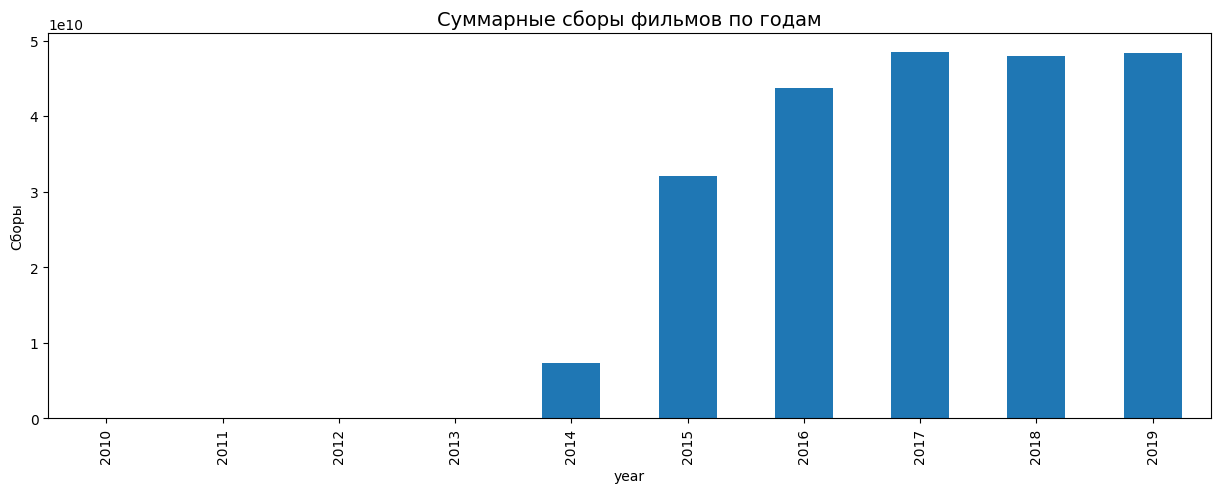

In [123]:
sum_box_office = raw_data.groupby('year')['box_office'].sum()

plt.subplots(figsize=(15, 5))
plt.title("Суммарные сборы фильмов по годам",fontsize=14)
plt.xlabel("Годы",fontsize=10)
plt.ylabel("Сборы",fontsize=10)
sum_box_office.plot.bar()
plt.show()

In [89]:
sum_box_office_without_support = raw_data.query('budget == 0 & year >=2013').groupby('year')['box_office'].sum()
sum_box_office_with_support = raw_data.query('budget != 0').groupby('year')['box_office'].sum()

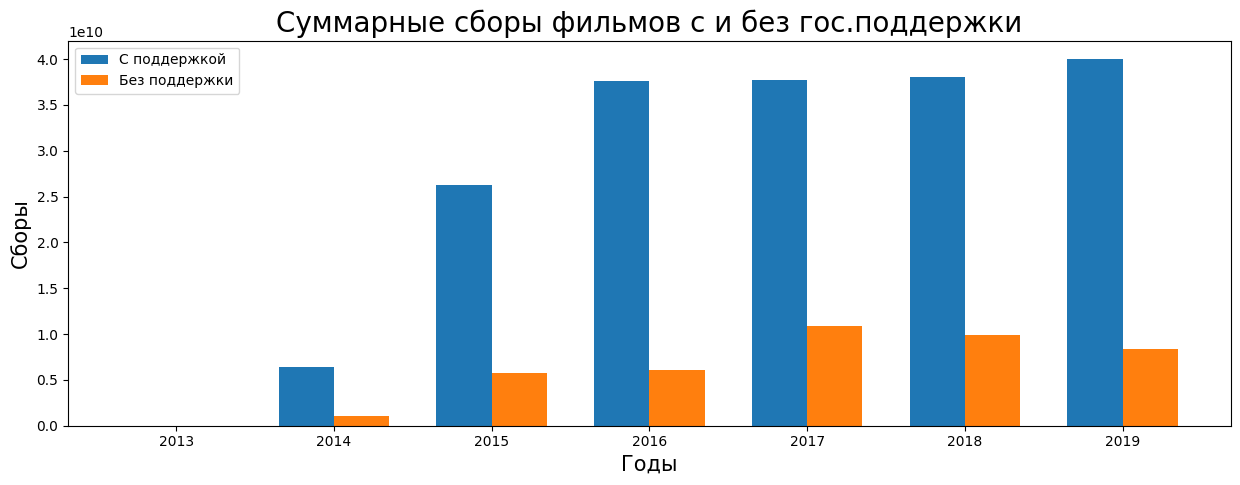

In [90]:
x = list(sum_box_office_without_support.index)
y1 = list(sum_box_office_without_support.values)
y2 = list(sum_box_office_with_support.values)
plt.figure(figsize=(15,5))
bar_width = 0.35

plt.bar(x, y1, width=bar_width, align='center', label='C поддержкой')
plt.bar([i + bar_width for i in x], y2, width=bar_width, align='center', label='Без поддержки')

plt.xlabel('Годы', fontsize=15)
plt.ylabel('Сборы', fontsize=15)
plt.title('Суммарные сборы фильмов с и без гос.поддержки', fontsize=20)
plt.xticks([i + 0.5*bar_width for i in x], x)  
plt.legend()

plt.show()

- С помощью сводной таблицы посчитайте среднюю и медианную сумму сборов для каждого года.

In [91]:
raw_data.query('box_office != 0').pivot_table\
(index='year', values=['box_office'], aggfunc=['mean', 'median', 'max', 'sum']).style.format("{:_.0f}")

,mean,median,max,sum
,box_office,box_office,box_office,box_office
year,,,,
2010,28_266,2_085,1_446_400,2_374_340
2011,142_290,3_042,11_618_085,13_944_390
2012,58_244,6_900,2_311_220,6_465_111
2013,174_085,3_880,19_957_032,29_768_531
2014,29_372_903,28_150,1_016_410_635,7_372_598_572
2015,74_964_135,4_398_304,1_646_580_646,32_084_649_858
2016,87_462_889,3_650_261,2_048_126_108,43_731_444_689
2017,136_408_860,10_177_834,2_779_686_144,48_561_554_267


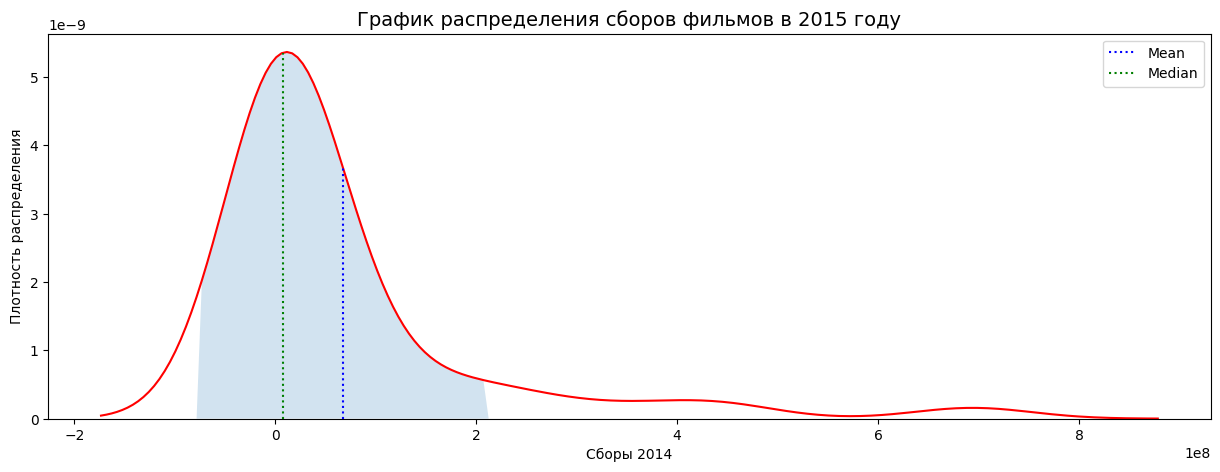

In [124]:
x = raw_data.query('year == 2015 & budget != 0')['box_office']
fig, ax = plt.subplots(figsize=(15, 5))
sns.kdeplot(x, color='red', ax=ax)
kdeline = ax.lines[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()
Mean = x.mean()
Median = x.median()
sdev = x.std()
left = Mean - sdev
right = Mean + sdev
plt.title("График распределения сборов фильмов в 2015 году",fontsize=14)
plt.xlabel("Сборы 2014",fontsize=10)
plt.ylabel("Плотность распределения",fontsize=10)
ax.vlines(Mean, 0, np.interp(Mean, xs, ys), label='Mean', color='blue', ls=':')
ax.vlines(Median, 0, np.interp(Median, xs, ys),label='Median', color='green', ls=':')
ax.fill_between(xs, 0, ys, where=(left <= xs) & (xs <= right), interpolate=True, alpha=0.2)
plt.legend()
plt.show()

- Определите, влияет ли возрастное ограничение аудитории («6+», «12+», «16+», «18+» и т. д.) на сборы фильма в прокате в период с 2015 по 2019 год? Фильмы с каким возрастным ограничением собрали больше всего денег в прокате? Меняется ли картина в зависимости от года? Если да, предположите, с чем это может быть связано.

In [93]:
def get_first_value(s, sep = '-'):
    value_lst = s.split(sep=sep)
    return value_lst[0]

In [94]:
raw_data['age_restriction'] = raw_data['age_restriction'].apply(lambda x: get_first_value(x, sep='-'))

In [95]:
raw_data.query('box_office != 0').pivot_table(
    index='age_restriction', values=['box_office'], aggfunc=['mean', 'median','sum']).style.format("{:_.0f}")

,mean,median,sum
,box_office,box_office,box_office
age_restriction,,,
«0+»,4_831_475,95_680,1_082_250_449
«12+»,118_015_260,906_638,61_485_950_304
«16+»,67_404_788,1_774_270,69_494_336_819
«18+»,46_304_958,5_124_405,38_896_164_910
«6+»,151_789_101,6_252_884,57_224_491_159


In [96]:
raw_data.query('box_office != 0 and  2015 <= year <=2019').pivot_table(
    index=['year','age_restriction'], values=['box_office'], aggfunc=['mean','median','max','sum']).style.format("{:_.0f}")

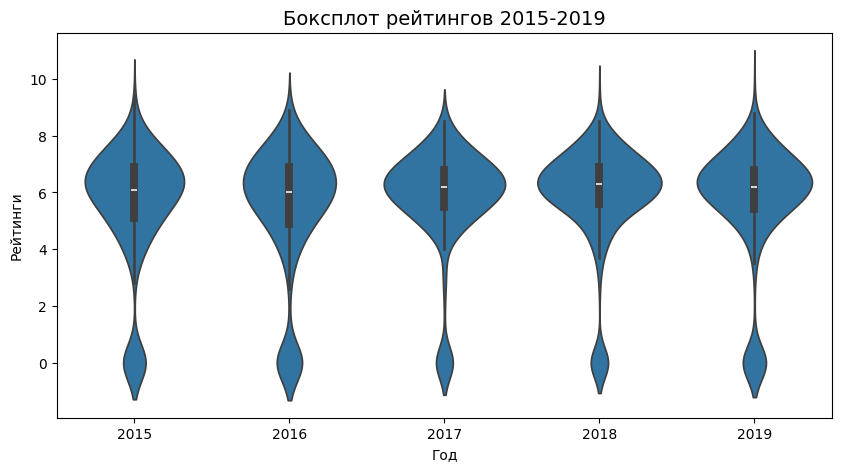

In [97]:
plt.figure(figsize=(10,5))

sns.violinplot(
    data=raw_data[(raw_data['year']  > 2014) & (raw_data['year'] <= 2019) & (raw_data['box_office'] != 0)],
    y="ratings",
    x="year")

plt.title("Боксплот рейтингов 2015-2019",fontsize=14)
plt.xlabel("Год",fontsize=10)
plt.ylabel("Рейтинги",fontsize=10)
plt.show()

In [98]:
dt_01 = raw_data[['age_restriction','ratings']]
gr_rating = dt_01.groupby('age_restriction').agg({'ratings':['mean']}).round()
dt_02 = pd.DataFrame(gr_rating.to_records())
dt_02.rename(columns={"('ratings', 'mean')": 'mean'}, inplace=True)

count_group = dt_01.groupby('age_restriction').agg({'ratings':['count']})
dt_03 = pd.DataFrame(count_group.to_records())
dt_03.rename(columns={"('ratings', 'count')": 'count'}, inplace=True)

groups_data = pd.merge(dt_02, dt_03).assign(percentage=lambda x: (x['count'] / dt_03['count'].sum()).round(2))
groups_data


,age_restriction,mean,count,percentage
0,«0+»,4.0,749,0.11
1,«12+»,6.0,1480,0.22
2,«16+»,6.0,2513,0.37
3,«18+»,6.0,1427,0.21
4,«6+»,6.0,603,0.09


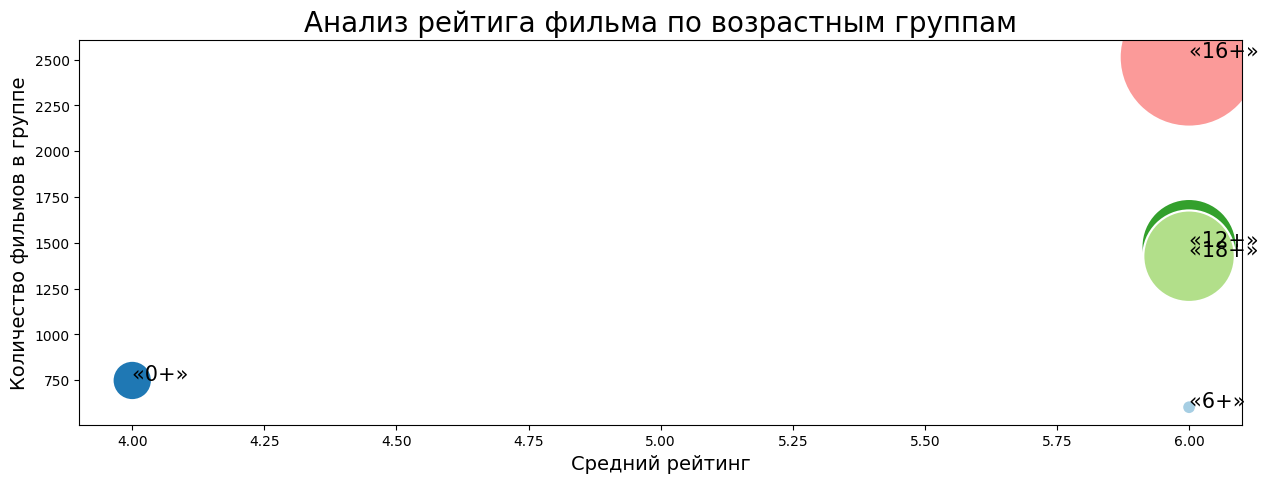

In [125]:
plt.figure(figsize=(15,5))

ax = sns.scatterplot(
    x=groups_data['mean'],
     y=groups_data['count'],
      hue=groups_data['percentage'],
      size=groups_data['percentage'],
       legend=False,
        sizes=(100, 10000),
         palette="Paired"
         )

plt.title("Анализ рейтига фильма по возрастным группам",fontsize=20)
plt.xlabel("Средний рейтинг",fontsize=14)
plt.ylabel("Количество фильмов в группе",fontsize=14)
for line in range(0, groups_data.shape[0]):
    ax.text(groups_data['mean'][line],
             groups_data['count'][line],
               groups_data['age_restriction'][line],
                 horizontalalignment='left', size=15)
plt.show()

Чаще всего оценили фильмы с ограничением 16+, меньше - 6+. Группы 16+, 12+, 18+, 6+ имеют одинаковую среднюю оценку

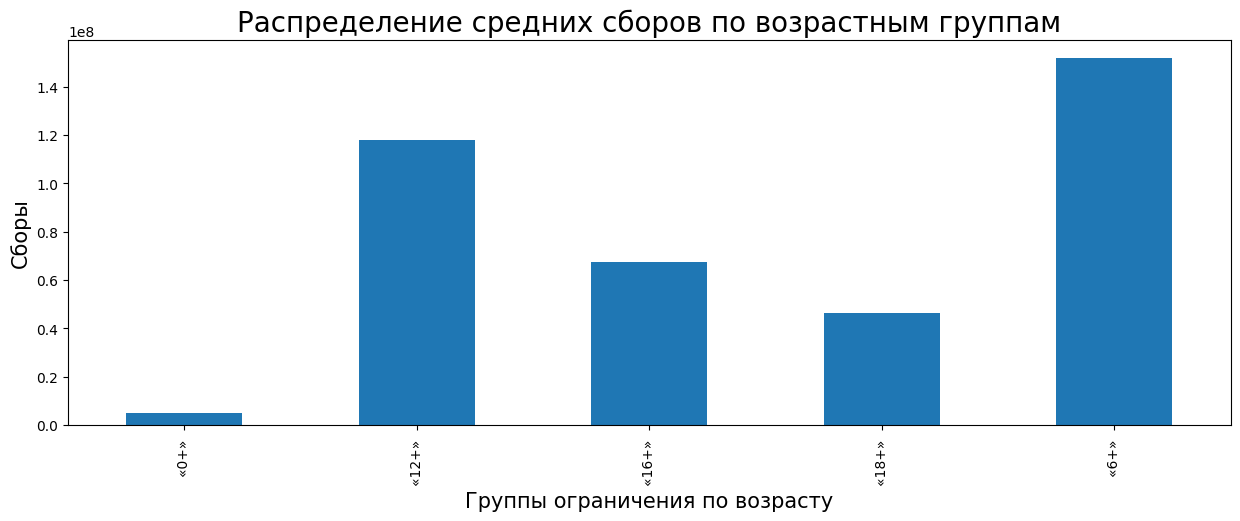

In [100]:
mean_box_office = raw_data[(raw_data['box_office'] != 0)].groupby('age_restriction')['box_office'].mean()
mean_box_office.plot.bar(figsize=(15, 5))
plt.title('Распределение средних сборов по возрастным группам', fontsize=20)
plt.ylabel("Сборы", fontsize=15)
plt.xlabel("Группы ограничения по возрасту", fontsize=15)
plt.show()

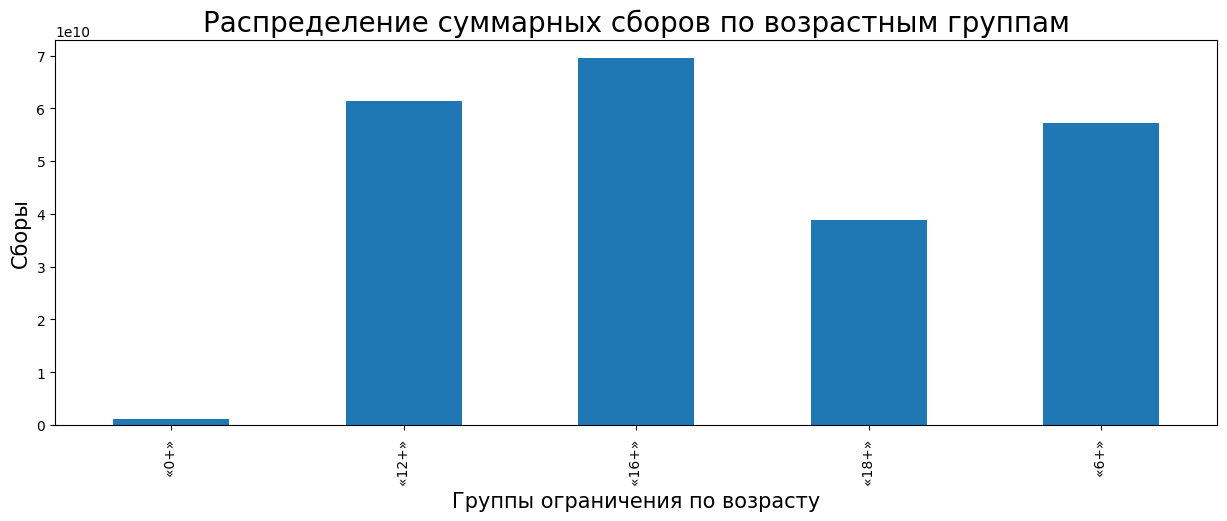

In [101]:
sum_box_office = raw_data[(raw_data['box_office'] != 0)].groupby('age_restriction')['box_office'].sum()
sum_box_office.plot.bar(figsize=(15, 5))
plt.title('Распределение суммарных сборов по возрастным группам', fontsize=20)
plt.ylabel("Сборы", fontsize=15)
plt.xlabel("Группы ограничения по возрасту", fontsize=15)
plt.show()

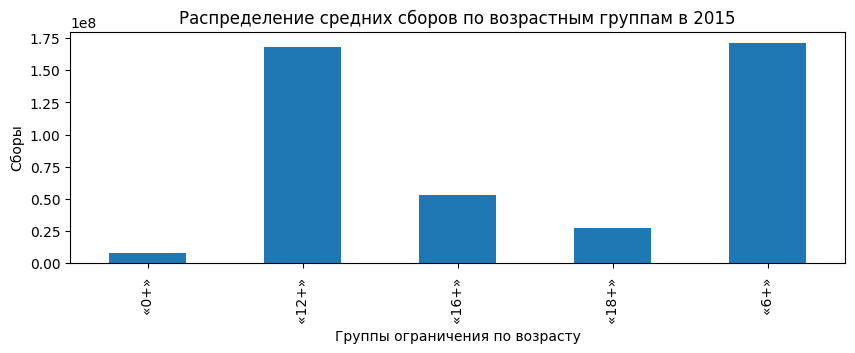

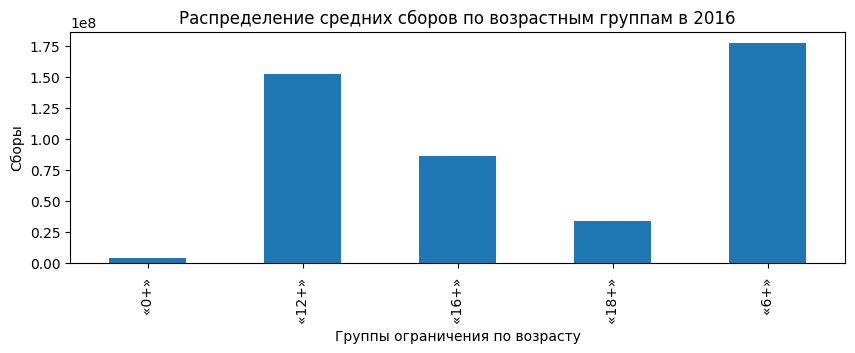

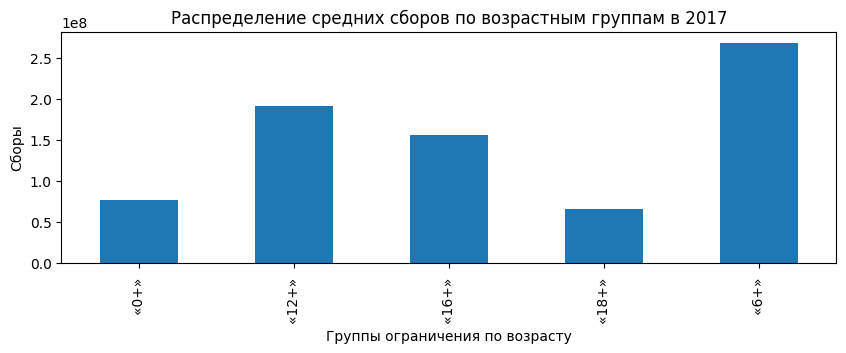

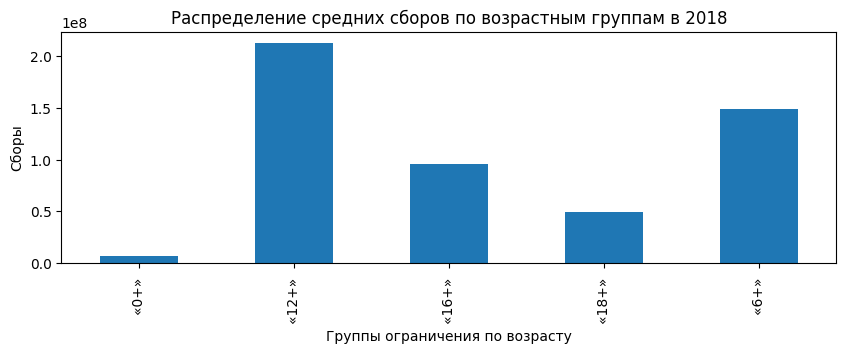

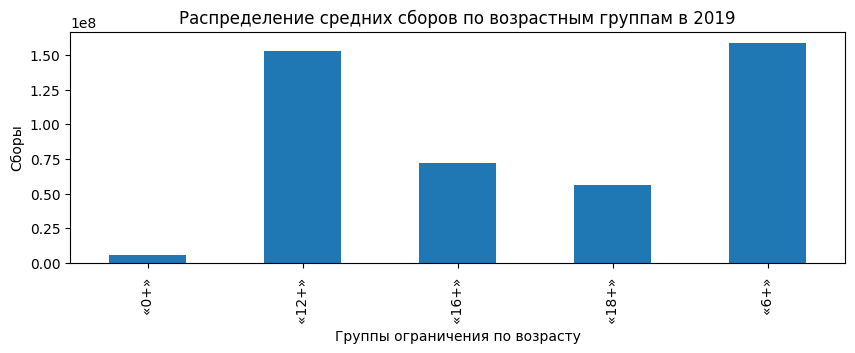

In [102]:
year_list = raw_data.query('2015 <= year <= 2019').groupby('year')['year'].count().index
for i in year_list:
    mean_box_office_i = raw_data[(raw_data['box_office'] != 0) & (raw_data['year'] == i)]\
        .groupby('age_restriction')['box_office'].mean()
    mean_box_office_i.plot.bar(figsize=(10, 3))
    plt.title('Распределение средних сборов по возрастным группам в ' + str(i))
    plt.ylabel("Сборы")
    plt.xlabel("Группы ограничения по возрасту")
    plt.show()

Паттерн средних сборов фильмов с 2015 по 2019 года примерно одинаковый: больше всего среднюю кассу собирают фильмы 6+ и 12+, затем идут фильмы 16+ и потом 18+. Меньше всего собирают фильмы без возрастных ограничеий.

In [103]:
sum_budget_studio = raw_data.query('budget != 0').groupby('film_studio')['budget'].sum().nlargest(10)

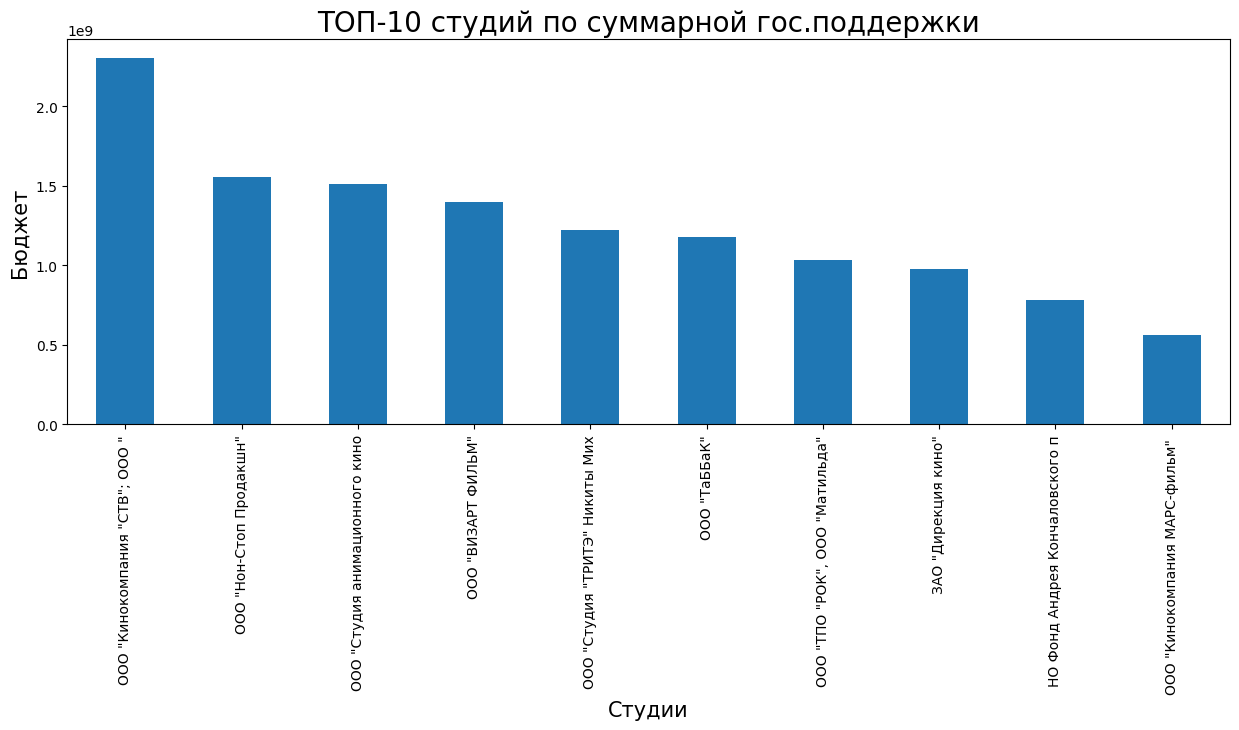

In [104]:
labels = list(map(lambda i:i[:30],sum_budget_studio.index))
sum_budget_studio.plot.bar(figsize=(15, 5)).set_xticklabels(labels)

plt.title('ТОП-10 студий по суммарной гос.поддержки', fontsize=20)
plt.ylabel("Бюджет", fontsize=15)
plt.xlabel("Студии", fontsize=15)

plt.show()

In [105]:
sum_nonrefundable_support = raw_data.query('budget != 0').groupby\
    ('year')['nonrefundable_support'].sum()

sum_refundable_support = raw_data.query('budget != 0').groupby\
    ('year')['refundable_support'].sum()

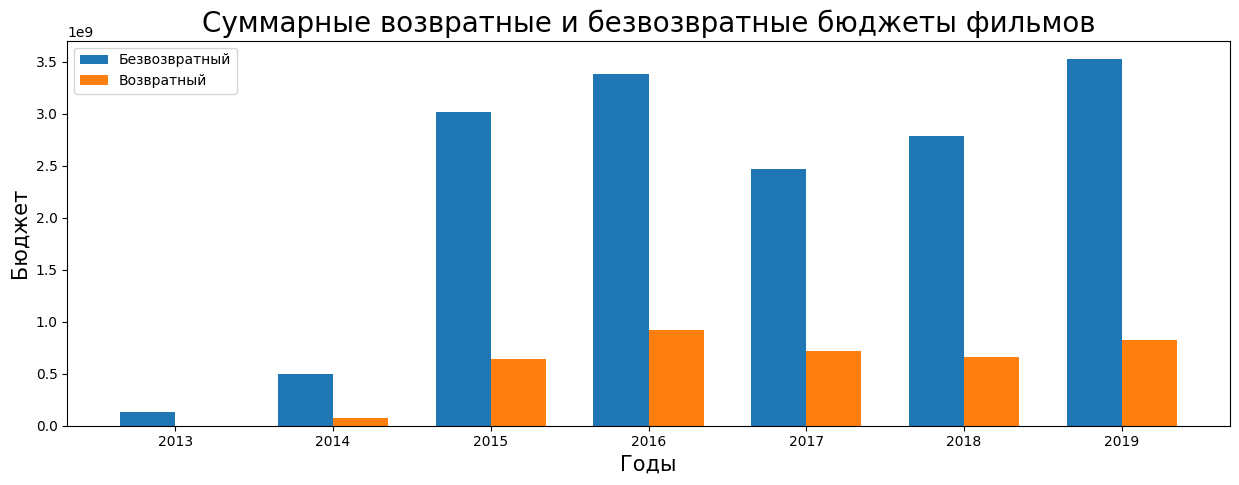

In [106]:
x = list(sum_nonrefundable_support.index)
y1 = list(sum_nonrefundable_support.values)
y2 = list(sum_refundable_support.values)
plt.figure(figsize=(15,5))
bar_width = 0.35

plt.bar(x, y1, width=bar_width, align='center', label='Безвозвратный')
plt.bar([i + bar_width for i in x], y2, width=bar_width, align='center', label='Возвратный')

plt.xlabel('Годы', fontsize=15)
plt.ylabel('Бюджет', fontsize=15)
plt.title('Суммарные возвратные и безвозвратные бюджеты фильмов', fontsize=20)
plt.xticks([i + 0.5*bar_width for i in x], x)  
plt.legend()

plt.show()

С 2014 года в структуре гос.поддержки появилась возвратная доля бюджета.

In [107]:
mean_box_office_with_support = raw_data.query('budget != 0 & box_office != 0').groupby\
    ('year')['box_office'].mean()

mean_box_office_without_support = raw_data.query('budget == 0 & box_office != 0').groupby\
    ('year')['box_office'].mean()

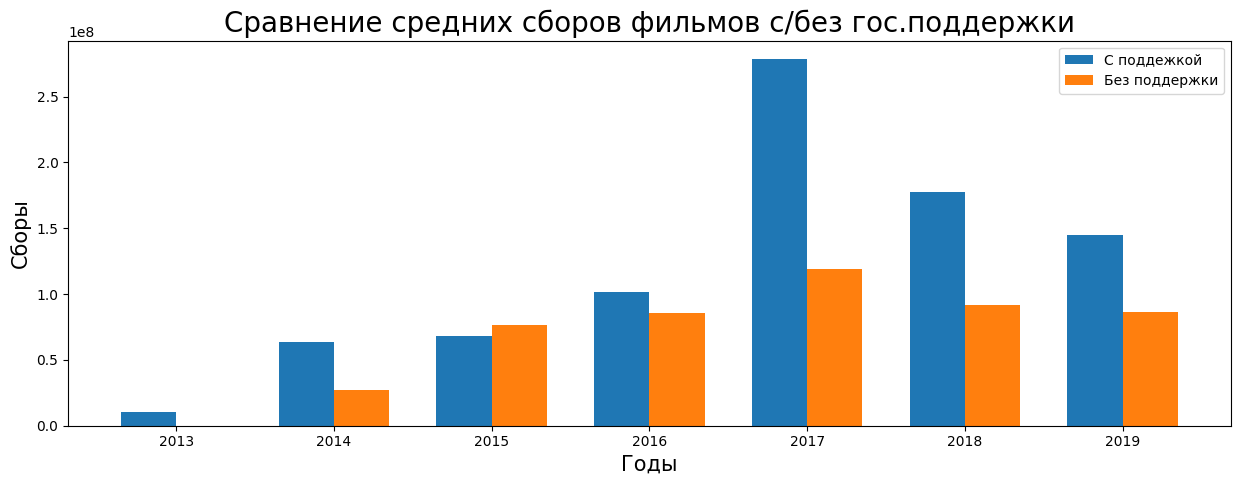

In [108]:
x = list(mean_box_office_without_support.index)[3:]
y1 = list(mean_box_office_with_support.values)
y2 = list(mean_box_office_without_support.values)[3:]
plt.figure(figsize=(15,5))
bar_width = 0.35

plt.bar(x, y1, width=bar_width, align='center', label='С поддежкой')
plt.bar([i + bar_width for i in x], y2, width=bar_width, align='center', label='Без поддержки')

plt.xlabel('Годы', fontsize=15)
plt.ylabel('Сборы', fontsize=15)
plt.title('Сравнение средних сборов фильмов с/без гос.поддержки', fontsize=20)
plt.xticks([i + 0.5*bar_width for i in x], x)  
plt.legend()

plt.show()

В 2015 году средние сборы фильмов с гос.поддержкой практически сравнялись со сборами фильмов без поддержки. А с 2016 года регулярно их превышали. Самый большой разрыв в 2017 году.

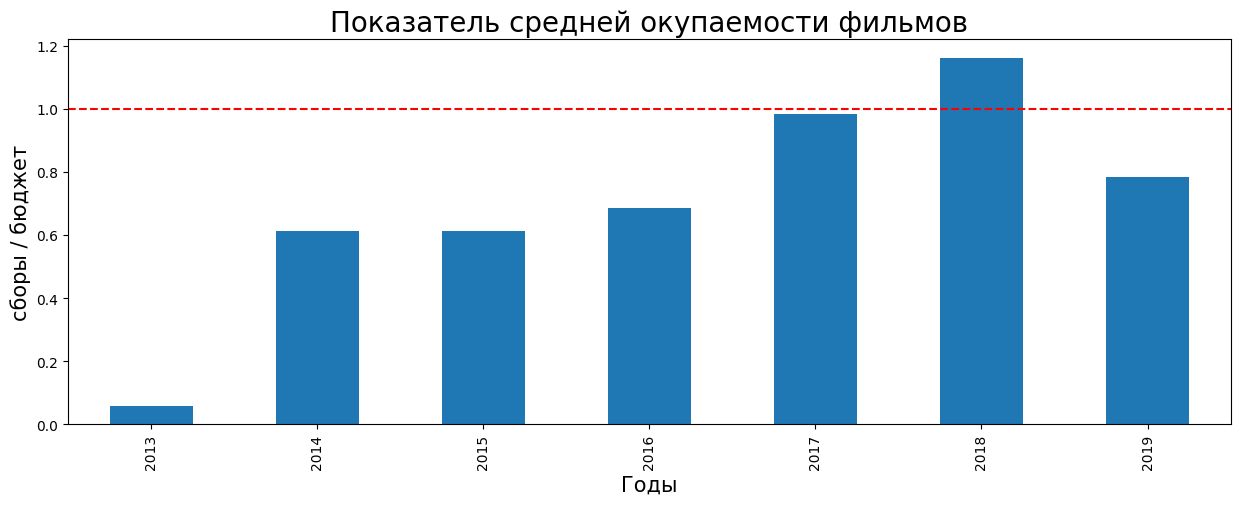

In [109]:
budget_return = raw_data.query('budget != 0').assign\
    (budget_return = lambda x: (x['box_office']/x['budget'])).groupby('year')['budget_return'].mean()
plt.figure(figsize=(15,5))
budget_return.plot.bar()
plt.axhline(y=1.0, color='r', linestyle='--')
plt.xlabel('Годы', fontsize=15)
plt.ylabel('сборы / бюджет', fontsize=15)
plt.title('Показатель средней окупаемости фильмов', fontsize=20)
plt.show()

Государственная поддержка начинается с 2013 года и ежегодно растет. Однако в большинстве случаев сборы на покрывают затраты и только в 2017 году они сравнялись, а в 2018 году превысили.

In [110]:
sum_box_office_with_support = raw_data.query('budget != 0 & box_office != 0').groupby\
    ('year')['box_office'].sum()

sum_box_office_without_support = raw_data.query('budget == 0 & box_office != 0').groupby\
    ('year')['box_office'].sum()

sum_budget = raw_data.query('budget != 0').groupby\
    ('year')['budget'].sum()

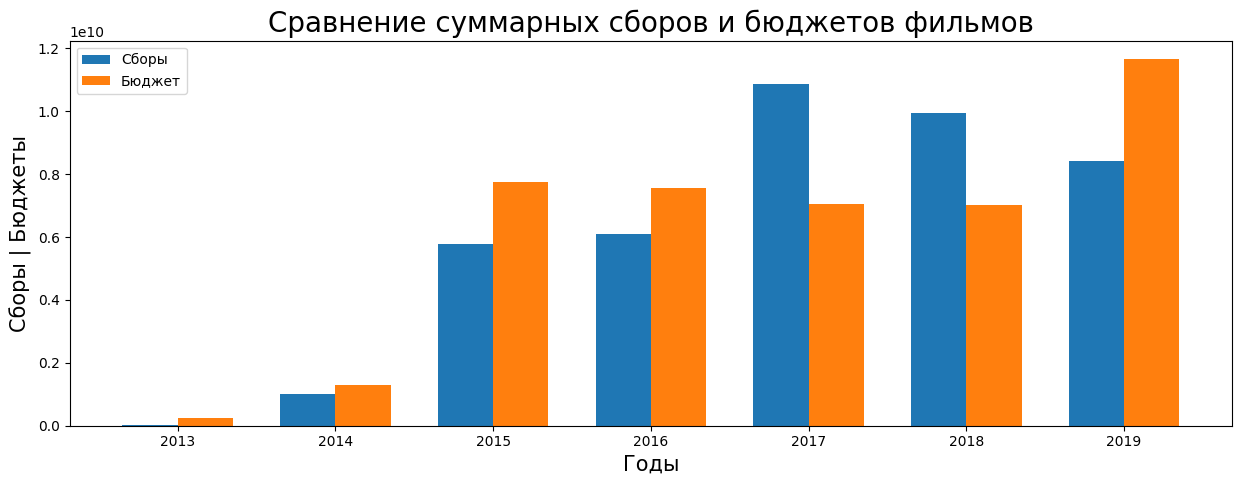

In [111]:
x = list(sum_box_office_with_support.index)
y1 = list(sum_box_office_with_support.values)
y2 = list(sum_budget.values)
plt.figure(figsize=(15,5))
bar_width = 0.35

plt.bar(x, y1, width=bar_width, align='center', label='Сборы')
plt.bar([i + bar_width for i in x], y2, width=bar_width, align='center', label='Бюджет')

plt.xlabel('Годы', fontsize=15)
plt.ylabel('Сборы | Бюджеты', fontsize=15)
plt.title('Сравнение суммарных сборов и бюджетов фильмов', fontsize=20)
plt.xticks([i + 0.5*bar_width for i in x], x)  
plt.legend()

plt.show()

Общие сборы поддтверждают общую тендецию об успешности 2017 и 2018 года. Однако общие сборы в 2017 году больше всего превысили бюджеты, при том что показатель средние сборы/срендий бюджет был около 1. Это говорит о нескольких супер успешных проектов, значительно окупившых бюджет.

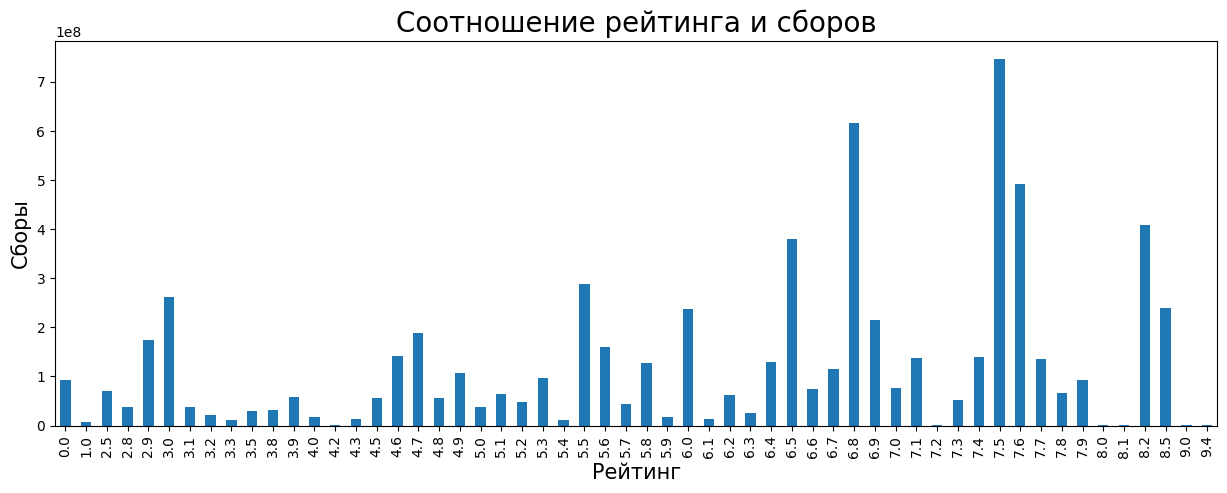

In [112]:
plt.figure(figsize=(15,5))
raw_data.query('budget != 0').groupby('ratings')['box_office'].mean().plot.bar()
plt.xlabel('Рейтинг', fontsize=15)
plt.ylabel('Сборы', fontsize=15)
plt.title('Соотношение рейтинга и сборов', fontsize=20)
plt.show()

C:\Users\kushn\AppData\Roaming\Python\Python312\site-packages\pandas\plotting\_matplotlib\misc.py:121: RuntimeWarning: invalid value encountered in cast
  if np.all(locs == locs.astype(int)):


PearsonRResult(statistic=0.06547666032022346, pvalue=6.92875424905125e-08)


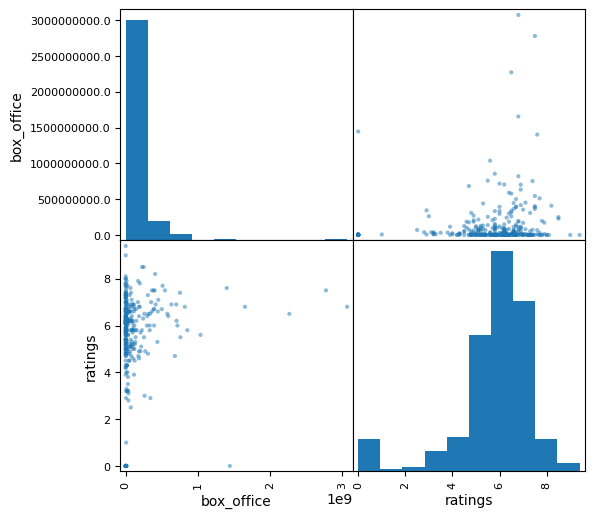

In [113]:
pd.plotting.scatter_matrix(raw_data.query('budget != 0')[['box_office','ratings']], figsize=(6,6));
print(stats.pearsonr(raw_data['box_office'], raw_data['ratings']))

Корреляция между рейтингом и сборами очень низкая, что также говорит в пользу искусственной природы значений рейтинга

In [114]:
# check
(
    raw_data
        .query('budget != 0')
        .assign(budget_return = lambda x: (x['box_office'] - x['budget']))
        .groupby('year')['budget_return'].sum()
        .to_frame()
        .style.format("{:_.0f}")
)

,budget_return
year,
2013,-235_113_005
2014,-285_062_616
2015,-1_953_383_789
2016,-1_473_234_909
2017,3_807_902_733
2018,2_933_404_911
2019,-3_251_678_756


In [115]:
mean_box_office_age = raw_data.query('budget != 0').groupby('age_restriction')['box_office'].mean()

mean_budget_age = raw_data.query('budget != 0').groupby('age_restriction')['budget'].mean()

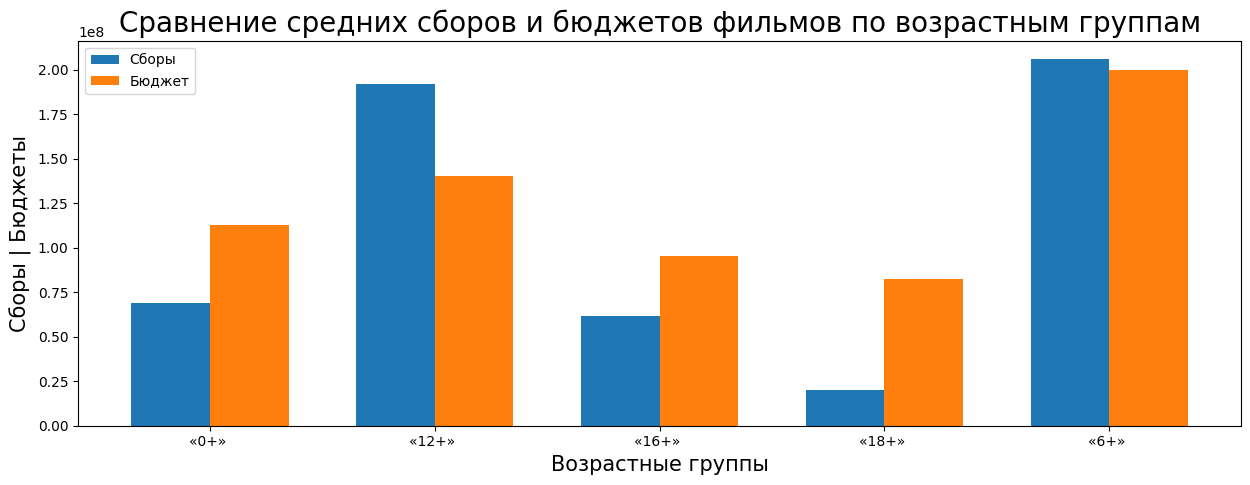

In [116]:
x = list(mean_box_office_age.index)
y1 = list(mean_box_office_age.values)
y2 = list(mean_budget_age.values)

plt.figure(figsize=(15,5))
bar_width = 0.35

plt.bar(x, y1, width=bar_width, align='center', label='Сборы')
plt.bar([i + bar_width for i in range(len(x))], y2, width=bar_width, align='center', label='Бюджет')

plt.xlabel('Возрастные группы', fontsize=15)
plt.ylabel('Сборы | Бюджеты', fontsize=15)
plt.title('Сравнение средних сборов и бюджетов фильмов по возрастным группам', fontsize=20)
plt.xticks([i + 0.5*bar_width for i in range(len(x))], x)  
plt.legend()

plt.show()

Больше всего гос.поддержка идет на фильмы 6+. 12+ фильмы самые успешные в плане окупаемости.

In [117]:
top_3_studio = raw_data.query('budget !=0').groupby('film_studio')['box_office'].sum().nlargest(3).sort_values()

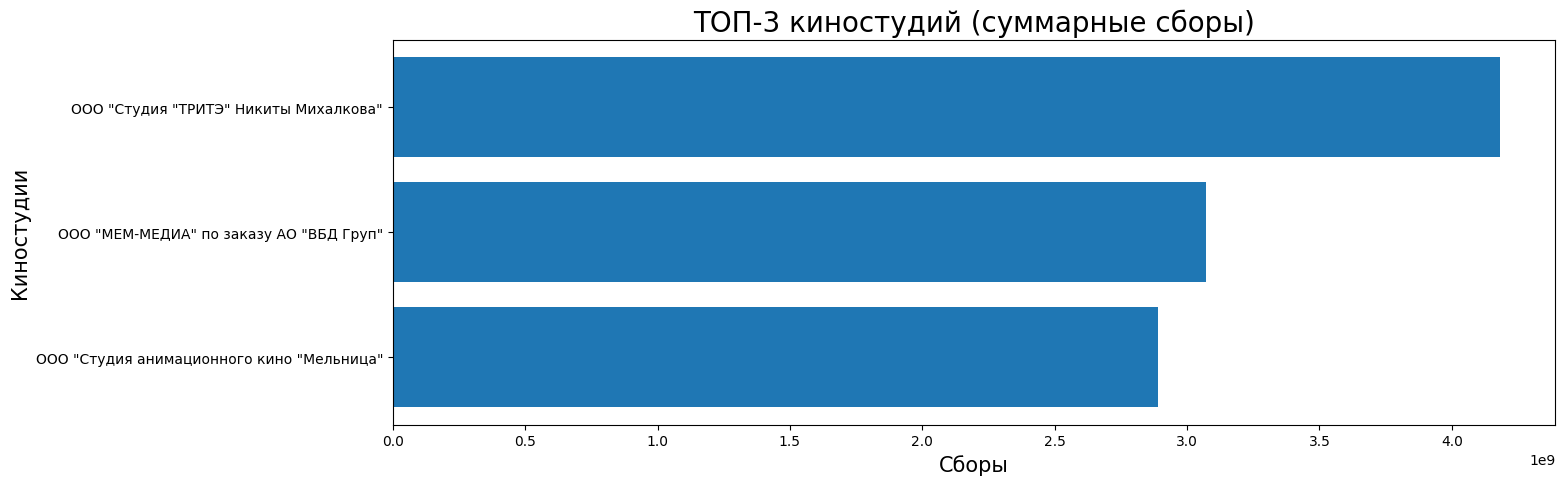

In [118]:
x = list(top_3_studio.index)
y = list(top_3_studio.values)

plt.figure(figsize=(15,5))
plt.barh(x, y)

plt.xlabel('Сборы', fontsize=15)
plt.ylabel('Киностудии', fontsize=15)
plt.title('ТОП-3 киностудий (суммарные сборы)', fontsize=20)

plt.show()

In [119]:
top_3_directors = raw_data.query('budget !=0').groupby('main_director')['box_office'].sum().nlargest(3).sort_values()

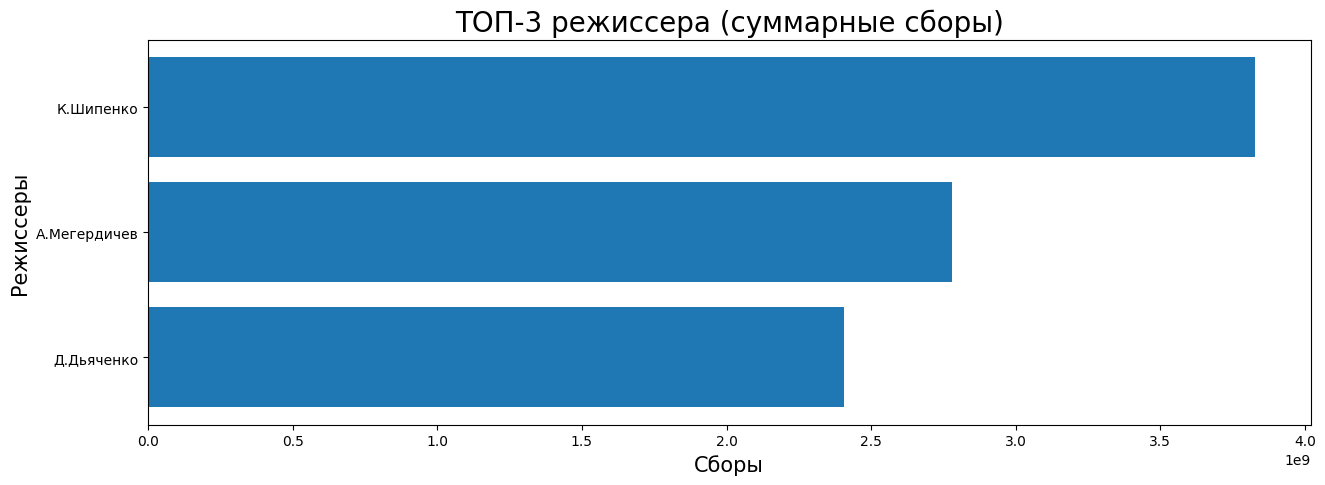

In [120]:
x = list(top_3_directors.index)
y = list(top_3_directors.values)

plt.figure(figsize=(15,5))
plt.barh(x, y)

plt.xlabel('Сборы', fontsize=15)
plt.ylabel('Режиссеры', fontsize=15)
plt.title('ТОП-3 режиссера (суммарные сборы)', fontsize=20)

plt.show()

In [121]:
top_3_movies = raw_data.query('budget !=0').groupby('title')['box_office'].sum().nlargest(3).sort_values()

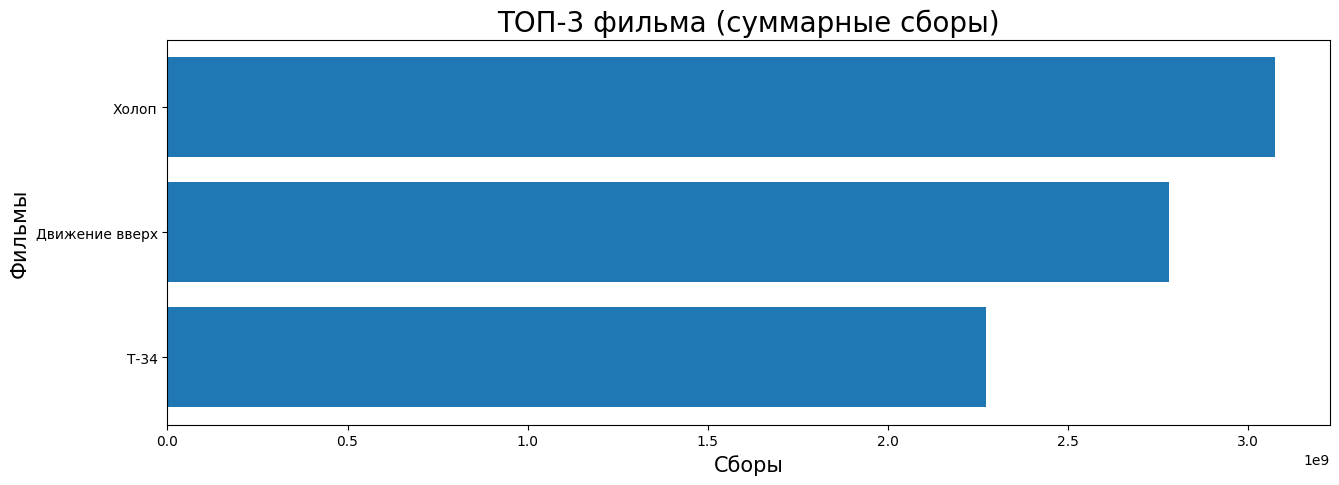

In [122]:
x = list(top_3_movies.index)
y = list(top_3_movies.values)

plt.figure(figsize=(15,5))
plt.barh(x, y)

plt.xlabel('Сборы', fontsize=15)
plt.ylabel('Фильмы', fontsize=15)
plt.title('ТОП-3 фильма (суммарные сборы)', fontsize=20)

plt.show()

## Выводы

Проведен анализ кассовых сборов фильмов в российском прокате с государственной поддержкой и без.
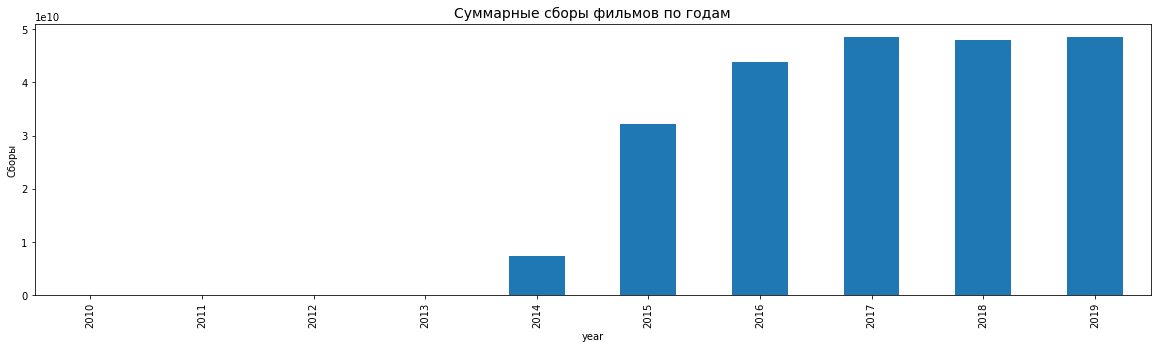

По сборам лидеруют фильмы с возрастным ограничением 6+

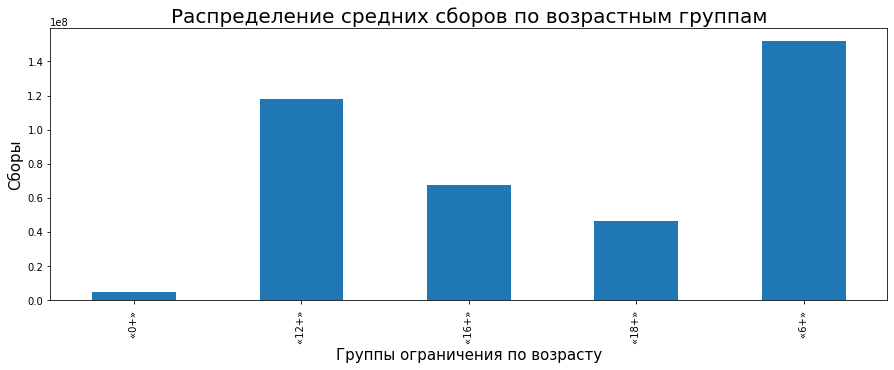

Хотя суммарно за всю исторю проката, фильмы с ограничением 16+ собрали больше

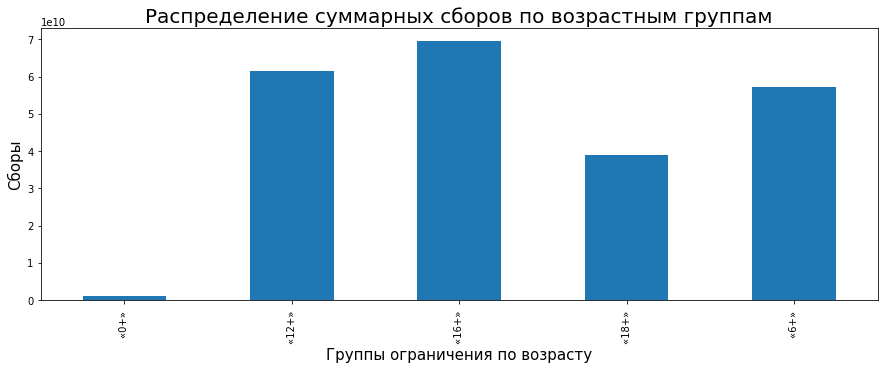

с 2015 года наблюдается активный рост кассовых сборов обусловленный увеличением государственной поддержки кинематографа. Фильмы с гос.поддержкой обгоняют по сборам фильмы без поддержки.

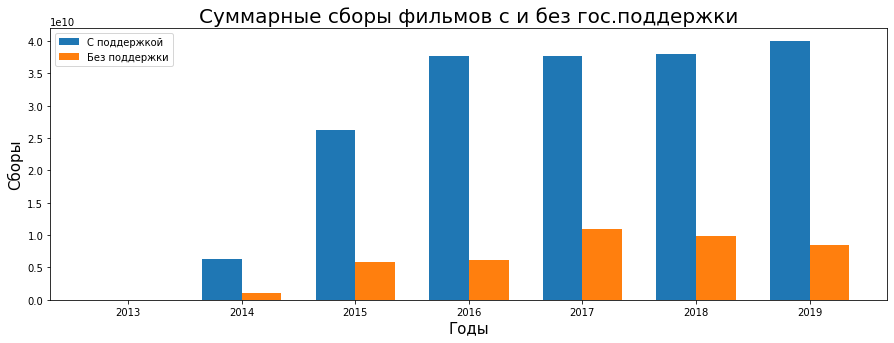
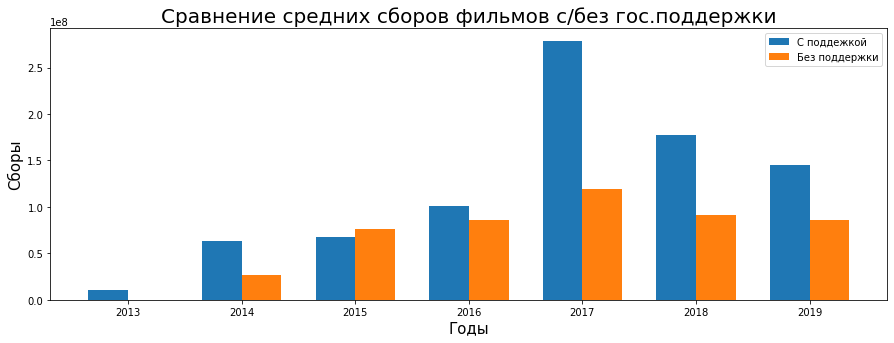

Гос.поддержка разделена на возвратную и невозвратную часть.

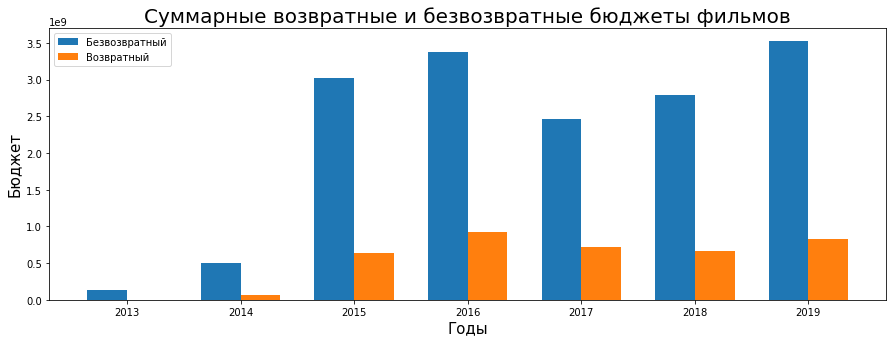

Доля поддержки в общем бюджете фильма находится в диапазоне от 30% до 70%. Со средним значением 50%.
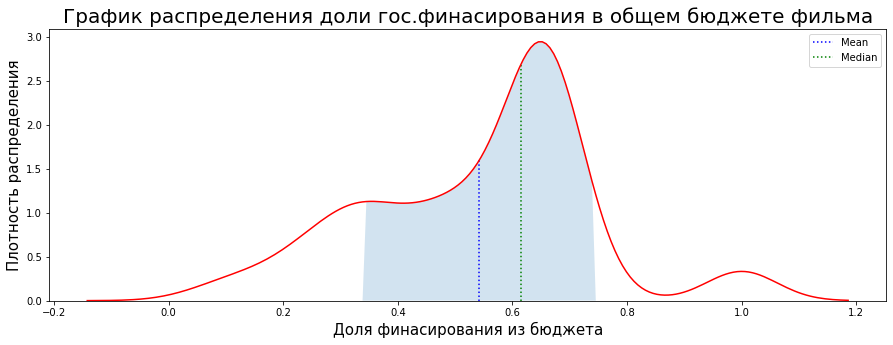

Больше всего гос.поддержку получили фильмы с ограничением 6+. 

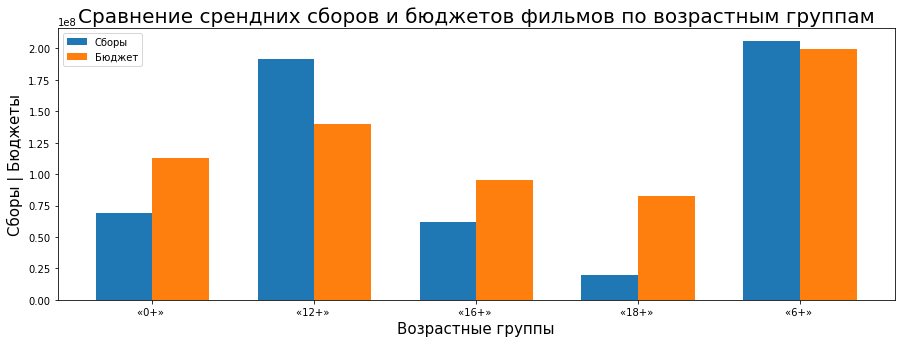

ТОП-10 студий по суммарно выделенной поддержке.

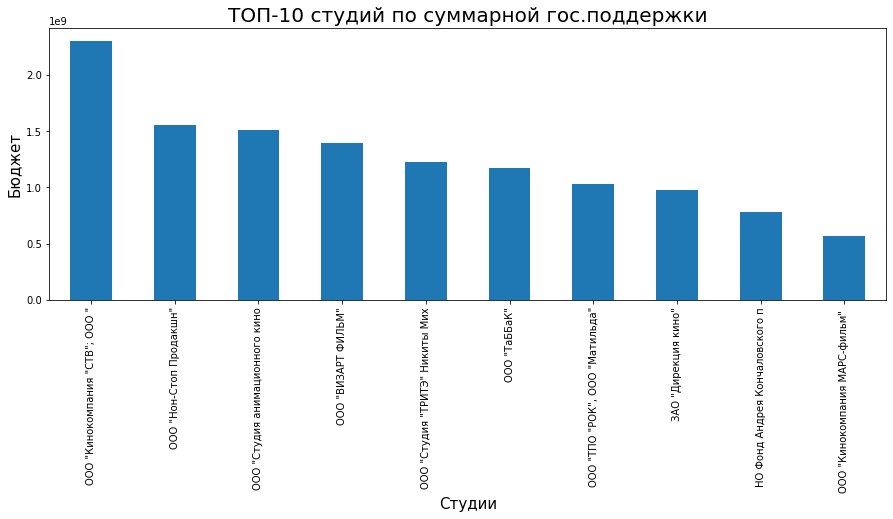 

Однако в большинстве случаев сборы на покрывают затраты.

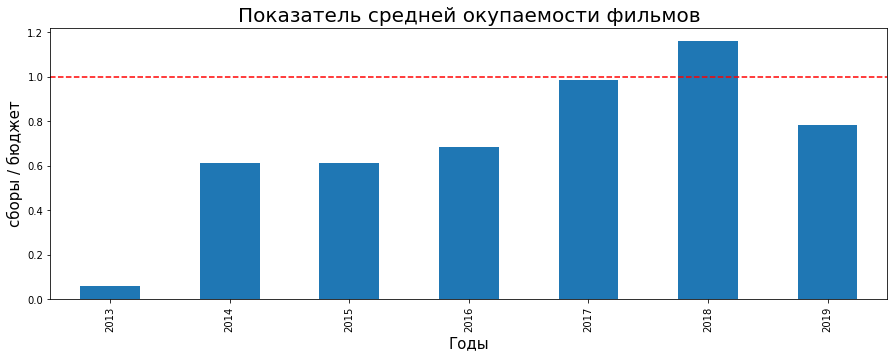

2017 и 2018 годы были наиболее успешними по соотношению суммарных сборов к суммарному бюджету

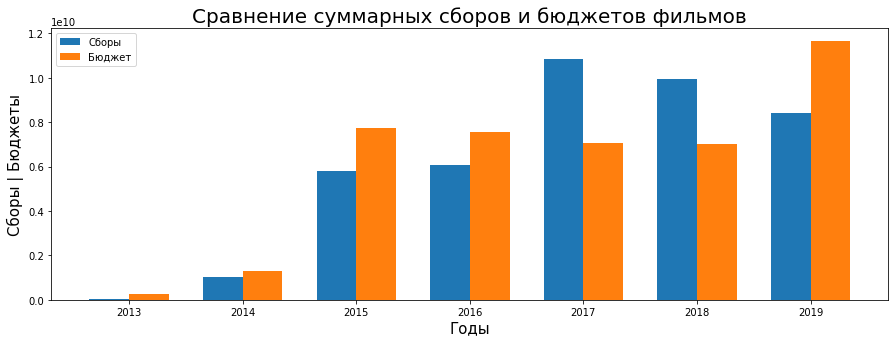

ТОП-3 фильма по сборам с гос.поддержкой

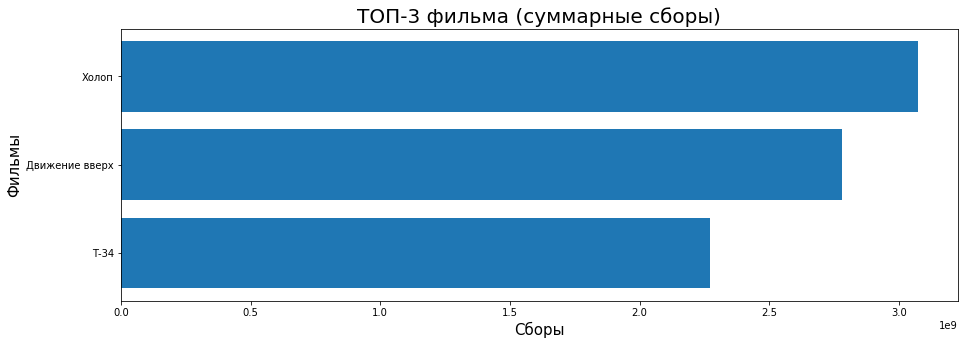

ТОП-3 киностудии по сборам с гос.поддержкой

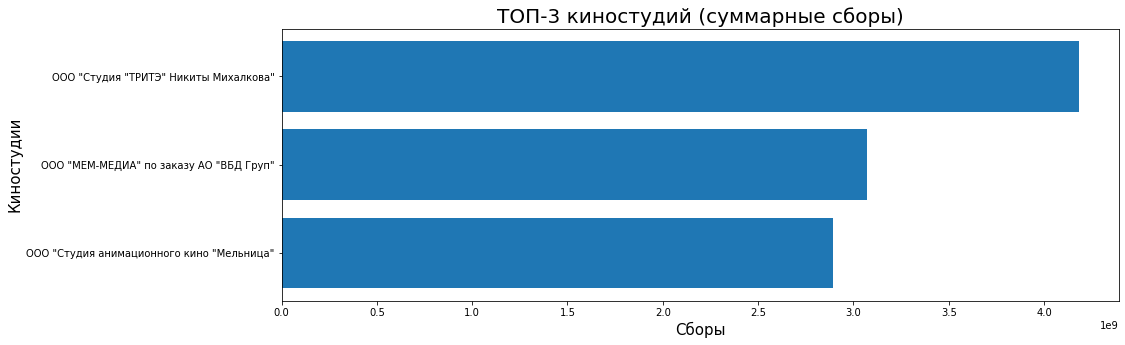

ТОП-3 режисера по сборам с гос.поддержкой

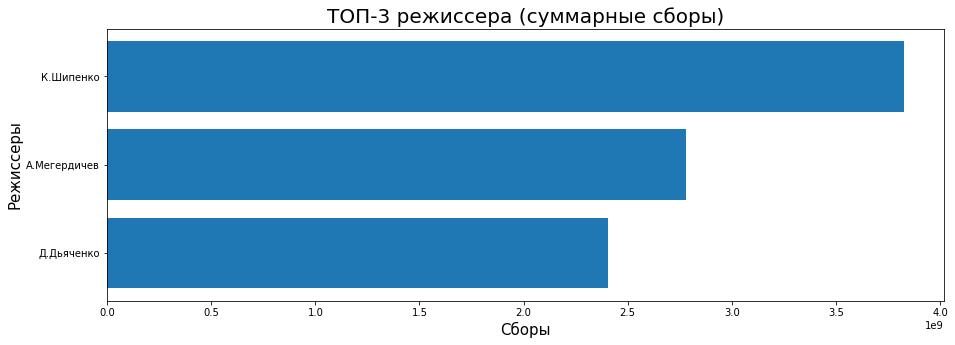